In [2]:
import pandas as pd
pd.options.display.max_colwidth=100 # default value = 50
import numpy as np
import re
import string
import os
import toolz as ct
import joblib
from gensim.parsing import preprocessing
from gensim.models import Word2Vec
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from wordcloud import WordCloud
import spacy



import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import nltk 
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet

''' all the following nltk.download('something') are needed only once '''
#nltk.download('averaged_perceptron_tagger')
#nltk.download('punkt') # for lemmatization
#nltk.download('stopwords')
#nltk.download('universal_tagset') for pos_tag() function
#nltk.download('wordnet') # for lemmatization 



" all the following nltk.download('something') are needed only once "

# Web Scrapping

## get text from a webpage (with bs4)

In [2]:
from bs4 import BeautifulSoup
import requests 
from time import sleep

In [ ]:
# Get HTML from webpage
page = requests.get('https://subslikescript.com/movie/Titanic-120338').text  
soup = BeautifulSoup(page, 'lxml')
#print(soup.prettify())  # print HTML code neatly

In [ ]:
# find content
title = soup.find('article', class_='main-article').find('h1').get_text(strip=True)
subtitles = soup.find('div', class_='full-script').get_text(strip=True, separator=' ') # get text from class 'full-script'(tagged with div). strip=True delete \n and separator replace it for ' '
print(title, '\n' ,subtitles)

In [4]:
# save content into a .txt
with open(f'{title}.txt', 'w') as file:
    file.write(subtitles)


## get data from a table in a webpage (with bs4)

In [3]:
# get table data
page = requests.get('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies').text
soup = BeautifulSoup(page, 'lxml')
#print(soup.prettify())


In [17]:
# get table data and create a dataframe from it
table = soup.find('table', class_='wikitable sortable')  
table_head = [i.get_text(strip=True) for i in table.find_all('tr')[0].find_all('th')] # get names of columns
table_head.pop(2) #delete not required columns
table_body = []
for i, th in enumerate(table.find_all('tr')[0].find_all('th')):  # get data from top to bottom and left to right
    if th.get_text(strip=True) in table_head:
        column = [j.find_all('td')[i].get_text(strip=True) for j in table.find_all('tr')[1:]]
        table_body.append(column)
    else: 
        next

dicc = {head:body for (head,body) in zip(table_head, table_body)}
df = pd.DataFrame(dicc)
df.head()


,Symbol,Security,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
498,YUM,Yum! Brands,Restaurants,"Louisville, Kentucky",1997-10-06,0001041061,1997
499,ZBRA,Zebra Technologies,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,0000877212,1969
500,ZBH,Zimmer Biomet,Health Care Equipment,"Warsaw, Indiana",2001-08-07,0001136869,1927
501,ZION,Zions Bancorporation,Regional Banks,"Salt Lake City, Utah",2001-06-22,0000109380,1873
502,ZTS,Zoetis,Pharmaceuticals,"Parsippany, New Jersey",2013-06-21,0001555280,1952


# Text cleansing

In [3]:
# read data and drop rows without answer
file_path = os.path.join('.','rawdata','intake_assesment_postgres.csv')
df = pd.read_csv( file_path , usecols=[1,2,3])
df.dropna(subset="value", inplace=True)
df.value[(df.value.str.contains('sdf') ) | (df.value.str.len() <4) | (df.value == 'none') | (df.value == 'NOne') | (df.value=='dsds')] = None
df.dropna(subset="value", inplace=True)

In [4]:
# Separate complaints from improvement suggestion
complaints  = df[df.key.str.contains("complaint")]
goals = df[df.key.str.contains("goal")]

In [5]:
# set data type to answers and dates
complaints = complaints.astype({'key':str,'value':str})
complaints.answer_created_at = pd.to_datetime(complaints.answer_created_at, format='%Y-%m-%d')

goals = goals.astype({'key':str,'value':str})
goals.answer_created_at = pd.to_datetime(goals.answer_created_at, format='%Y-%m-%d')

In [6]:
# text cleansing function

def clean_text(texto, twitter=False, tag=False):
    
    '''for twitter text, Remove links, hashtags, at-mentions, mark-up, "RT", Non latin characters, and alone characters'''
    if twitter:
        texto = re.sub(r"http\S+", "", texto)
        texto = re.sub(r"@\S+", "", texto)
        texto = re.sub(r"#\S+", "", texto)
        texto = re.sub("<[^>]*>", "", texto)
        texto = texto.replace(" RT", "").replace("RT ", "")
        texto = re.sub(r'[^\x00-\x7f]',r'', texto)
        texto = re.sub('(\\b[A-Za-z] \\b|\\b [A-Za-z]\\b)', '', texto)
        texto = ct.pipe(
            texto,
            preprocessing.strip_tags,
            preprocessing.strip_punctuation,
            preprocessing.strip_numeric,
            preprocessing.strip_non_alphanum,
            preprocessing.strip_multiple_whitespaces,
        )
        # Strip, lowercase and split into list of 1-gram
        texto = texto.lower().strip().lstrip().split()
    else:
        """Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers, some additional punctuation and non-sensical text"""
        texto = texto.lower().strip()
        texto = re.sub("\[.*?¿\]\%", " ", texto)
        texto = re.sub("[%s]" % re.escape(string.punctuation), " ", texto)
        texto = re.sub("\w*\d\w*", "", texto)
        texto = re.sub("[‘’“”…«»]", "", texto)
        texto = re.sub("\n", " ", texto)
        
    if tag:
        if type(texto) == str:
            texto = texto.split()
        texto = [nltk.pos_tag([w], tagset='universal')[0][0] + "_" + nltk.pos_tag([w], tagset='universal')[0][1] for w in texto]
        
    return texto

In [6]:
complaints.value = complaints.value.apply(clean_text)
goals.value = goals.value.apply(clean_text)
complaints.value.iloc[200]

'i want to be optimized to the hilt  living my best possible life  i ve explored hrt in the past and am looking heavily into peptides and other  performance enhancers   i had several concussions and severe brain swelling in my lesser years  so take cognitive performance and inflammation control very seriously  in short  i am in need of professional consultation and optimization assistance '

# Tokenization

In [ ]:
''' Tokenization example'''

sentence = '''Return a tokenized copy of *text*, using NLTK's recommended word tokenizer 
(currently an improved .TreebankWordTokenizer
along with .PunktSentenceTokenizer for the specified language).'''
words = nltk.word_tokenize(sentence)
words

In [ ]:
# example of word tokenization with spacy
from spacy.lang.en.examples import sentences 

nlp = spacy.load("en_core_web_sm")
doc = nlp(sentences[0])
print(doc.text)
for token in doc:
    print(token.text, token.pos_, token.dep_)

In [ ]:
# To separate the document in sentences with nltk 
text = """Dr David Megson, senior lecturer in chemistry and environmental forensics at Manchester Metropolitan University, told the BBC: "The overall risk is still what we would describe as relatively low, but it still just doesn't sit right with me that two different people can have different water resources and have a different risk of potentially dying from exposure to chemical pollution."
Traditional water treatment approaches cannot remove PFAS so water companies often blend different water sources together to dilute the concentration. Some are also trying out emerging technologies like high pressure membranes."""
from nltk.tokenize import sent_tokenize 
list_of_sentences = sent_tokenize(text.replace("\n", " ").replace("\xa0"," ").replace("\u2022","."))

In [ ]:
# example of sentence tokenization with spacy
nlp = spacy.load("en_core_web_sm")
list_of_sentences = [sent.text.strip() for sent in nlp(text).sents]

# Lemmatization

### Simple lemmatization

In [88]:
'''use lemmatizer to lemmatize each word from each answer, except for stopwords'''
lem = WordNetLemmatizer()
answer_lemm_list=[]
for answer in complaints.value:
    words = nltk.word_tokenize(answer)
    words = [lem.lemmatize(word) for word in words if word not in set(stopwords.words('english'))]
    answer_lemm= ' '.join(words)
    answer_lemm_list.append(answer_lemm)

complaints['value_lemm']= answer_lemm_list  # creates a new column in the dataframe of complaints with all the answers lemmatized

In [89]:
complaints.loc[181, ['value' ,'value_lemm'] ]

value         i want a customized plan for my health going i...
value_lemm    want customized plan health going latter part ...
Name: 181, dtype: object

### Lematization with POS(part of speech) tags

In [173]:

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [174]:
'''use lemmatizer to lemmatize each word from each answer, except for stopwords'''
lem_POS = WordNetLemmatizer()
answer_lemm_list=[]
for answer in complaints.value:
    words = nltk.word_tokenize(answer)
    words = [lem_POS.lemmatize(word= word, pos= get_wordnet_pos(word)) for word in words if word not in set(stopwords.words('english'))]
    answer_lemm= ' '.join(words)
    answer_lemm_list.append(answer_lemm)

complaints['value_lemm_POS']= answer_lemm_list  # creates a new column in the dataframe of complaints with all the answers lemmatized

In [178]:
complaints.loc[181, ['value','value_lemm_POS'] ] # ,'value_lemm'

value             i want a customized plan for my health going into the latter part of my life   i currently feel ...
value_lemm_POS        want customize plan health go latter part life currently feel generalize healthy longevity goal
Name: 181, dtype: object

# Vectorization

In [82]:
''' Example of vectorizing a text '''

from sklearn.feature_extraction.text import CountVectorizer
texto = "What is your biggest complaint or concern your"
texto = texto.lower().strip()

vectorizer = CountVectorizer()
vector = vectorizer.fit_transform([texto])
print(vector)

  (0, 5)	1
  (0, 3)	1
  (0, 6)	2
  (0, 0)	1
  (0, 1)	1
  (0, 4)	1
  (0, 2)	1


# Using vectorization to count frecuency

## Vectorization without lemmatization

In [90]:
vectorizer = CountVectorizer(max_features=30, stop_words='english', ngram_range=(1,2))  # instantiate vetorizer to take 30 words, eliminate stopwords, and count 1-grams and 2-grams
data_cv = vectorizer.fit_transform(complaints.value).toarray() # convert sparse matrix to array
data_cv[data_cv > 1] = 1 # set to 1 any value higher than 1(to not count more than one time one user)
words_freq= pd.DataFrame(data_cv, columns=vectorizer.get_feature_names_out())
words_freq.index= complaints.index # assign the same index from complaints
words_freq = words_freq.transpose()
words_freq

,8,19,21,26,33,40,41,43,47,55,...,20782,20783,20785,20787,20789,20792,20793,20795,20797,20800
better,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
body,1,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
energy,1,0,0,1,0,0,0,1,0,0,...,1,0,0,0,1,0,0,0,0,0
energy levels,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
fat,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
feel,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
focus,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
health,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
healthy,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
hormone,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0


In [91]:
'''calculate accumulate for each n-gram and sort descending'''
word_freq_sum = words_freq.sum(axis=1).sort_values(ascending=False)
word_freq_sum

energy           2211
weight           1201
health           1132
sleep             676
body              600
like              591
want              555
levels            543
overall           443
loss              439
better            420
fat               403
muscle            396
low               386
feel              381
mental            380
improve           376
healthy           364
pain              341
libido            336
energy levels     316
weight loss       298
lose              293
focus             288
increase          275
hormones          274
hormone           272
level             268
lack              264
just              238
dtype: int64

## Vectorization with simple lemmatization

In [ ]:
vectorizer = CountVectorizer(max_features=30, stop_words='english', ngram_range=(1,2))
data_cv = vectorizer.fit_transform(complaints.value_lemm).toarray()
data_cv[data_cv > 1] = 1
words_freq= pd.DataFrame(data_cv, columns=vectorizer.get_feature_names_out())
words_freq.index= complaints.index
words_freq = words_freq.transpose()
words_freq

In [99]:
word_freq_sum = words_freq.sum(axis=1).sort_values(ascending=False)
word_freq_sum

energy          2211
weight          1212
health          1132
level            802
sleep            676
body             601
like             591
want             555
hormone          543
energy level     503
overall          443
loss             440
better           420
muscle           409
fat              403
feel             395
low              389
pain             387
mental           380
improve          376
healthy          364
libido           336
weight loss      298
lose             293
focus            288
increase         278
lack             265
issue            262
need             247
year             238
dtype: int64

## vectorization with lemmatization with POS

In [ ]:
vectorizer = CountVectorizer(max_features=30, stop_words='english', ngram_range=(1,2))
data_cv = vectorizer.fit_transform(complaints.value_lemm_POS).toarray()
data_cv[data_cv > 1] = 1
words_freq= pd.DataFrame(data_cv, columns=vectorizer.get_feature_names_out())
words_freq.index= complaints.index
words_freq = words_freq.transpose()
words_freq

In [37]:
word_freq_sum = words_freq.sum(axis=1).sort_values(ascending=False)
word_freq_sum

energy          2211
weight          1212
health          1132
level            802
sleep            716
body             601
like             591
want             571
hormone          543
feel             538
energy level     503
improve          489
low              489
overall          443
loss             440
lose             426
muscle           409
fat              403
pain             387
mental           380
increase         365
healthy          364
libido           336
focus            314
age              310
weight loss      298
balance          278
lack             277
need             269
issue            262
dtype: int64

# ML with text

## Text classification with tf-idf vectorization of the text and ML classifiers.
<details>
    <summary>Click to see more!</summary>
    tf-idf(Term frequency – Inverse document frequency) vectorization method is useful when we want to extract distinctiveness between documents. it yields a vector whose higher values are assigned to frequent words in the document that are not frequent in the other documents.    
    - Unmasking: One method to evaluate the robustness of a classifier. The algorithm is based on the idea of feature pruning: we use a Linear Support Vector Machine for classification, which provides feature weights that tell us how important each of our function word n-grams is to the model. For 100 cycles, we train a new classifier and then remove the most important features. if the model is robust its performance won't decrease considerably through the 100 cycles. this method doesn't apply to NN.
</details>


### This is optional (PMI with nltk and tf-idf vectorizer example)

In [ ]:
'''Calculate PMI(Pointwise mutual information) using nltk to get a list of most likely bi-grams from survey data.
this is optional to the method .Phrases from gensim module'''
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures
from nltk.tokenize import word_tokenize

#nltk.download('punkt')
stopwords = nltk.corpus.stopwords.words('english')


answers_list = []
for answer in complaints.value_lemm_POS:
    words = [word for word in word_tokenize(answer) if word not in stopwords]
    answers_list.append(words)

# text = " ".join(complaints.value).replace("  "," ") # this is optional to use with method .from_words

bigram_measures = BigramAssocMeasures()
finder = BigramCollocationFinder.from_documents(answers_list)      #    .from_words([word for word in word_tokenize(text) if word not in stopwords])
finder.apply_freq_filter(min_freq=25)
for i in finder.score_ngrams(bigram_measures.pmi):
    if i[1]>1:
        print(i)

In [14]:
'''tf-idf vectorizer example'''

corpus = [
       'This is the first document.',
       'This document is the second document.',
       'And this is the third one.',
       'Is this the first document?',
       ]
vect = TfidfVectorizer()
data_tfidf= vect.fit_transform(corpus).toarray()
words_tfidf= pd.DataFrame(data_tfidf, columns=vect.get_feature_names_out())

words_tfidf

,and,document,first,is,one,second,the,third,this
0,0.000000,0.469791,0.580286,0.384085,0.000000,0.000000,0.384085,0.000000,0.384085
1,0.000000,0.687624,0.000000,0.281089,0.000000,0.538648,0.281089,0.000000,0.281089
2,0.511849,0.000000,0.000000,0.267104,0.511849,0.000000,0.267104,0.511849,0.267104
3,0.000000,0.469791,0.580286,0.384085,0.000000,0.000000,0.384085,0.000000,0.384085


### All begins loading the data!

In [7]:
"load data Twitter_by_City"
data_dir = os.path.join(".", "rawdata")
file = os.path.join(data_dir, "Twitter_by_City.gz")
df = pd.read_csv(file, index_col = 0)
df.head()

,City,Text
0,auckland,i m sorry who didn t vote beige show me these people so they can be publicly stoned is it distu...
1,auckland,meet our analysts idc australia new zealand analyst sean ashari analyses the future of work mar...
2,auckland,aue my great grandfather was an aboriginal tent boxer called lenny but i won t do a dna test my...
3,auckland,yeah dumping corsica would be a good idea totally unfair that france get wrc events i just call...
4,auckland,thank you for your partnership to help get delegates to just because you like their posts share...


### PMI with gensim
<details>
    <summary>Click to see more!</summary>
    The PMI (pointwise mutual information) represents a quantified measure for how much more- or less likely we are to see the two words co-occur. the class Phrases from gensim module automatically detect common phrases, multi-word expressions and word n-gram collocations from a stream of sentences.
</details>

In [179]:
'''take text into a array on string'''
# sentences(list of splitted or tokenized documents) from twitter 
#sentences = [clean_text(str(x), twitter=True) for x in df.Text.values] #[df.City=='paris']

# Sentences from medical survey
sentences = [clean_text(str(x)).split() for x in complaints.value_lemm_POS.values]

In [186]:
'''Use PMI to learn what phrases and collocations should be treated as one word'''
from gensim.models.phrases import Phrases, Phraser, ENGLISH_CONNECTOR_WORDS

phrases = Phrases(
                sentences = sentences,
                min_count = 25, 
                threshold = 0.5, # 0.7 for tweets, 0.5 for health survey
                scoring = "npmi",
                max_vocab_size = 100000000,
                connector_words= ENGLISH_CONNECTOR_WORDS
                )

phrases = Phraser(phrases)

In [187]:
'''show phrases and its score'''
phrases.phrasegrams

{'energy_level': 0.5655439418876155,
 'sex_drive': 0.9139651790891992,
 'body_fat': 0.6080723922511353,
 'lose_weight': 0.5762626483935107,
 'blood_sugar': 0.6296025620675678,
 'hot_flash': 0.9734838430502506,
 'year_ago': 0.6932545083056125,
 'overall_health': 0.5686333973450257,
 'belly_fat': 0.7068598691309314,
 'joint_pain': 0.6276896252219384,
 'weight_loss': 0.6441210910886513,
 'anti_age': 0.6636490057127065,
 'muscle_mass': 0.7802251073092604,
 'mental_clarity': 0.7460809133248921,
 'hormone_balance': 0.5643677296142093,
 'poor_sleep': 0.5133441770049586,
 'lean_muscle': 0.6179070827629239,
 'last_year': 0.6217329780169474,
 'hormone_optimization': 0.5316033813926935,
 'stay_healthy': 0.5230522685830626,
 'blood_pressure': 0.835102412870711,
 'hair_loss': 0.521149657182179,
 'would_like': 0.8162584842268878,
 'throughout_day': 0.7078112541543639,
 'ache_pain': 0.5869597359273965,
 'physically_mentally': 0.7514853434420552,
 'long_term': 0.8219684890506737,
 'big_concern': 0.614

### tf-idf vectorization

In [12]:
''' make a dictionary with the frequency of each word '''
from collections import defaultdict

vocab = defaultdict(int)

for line in sentences:
    line = list(phrases[line])
    for word in line:
        vocab[word] += 1

In [13]:
# get a list of words and phrases with a frequency higher than min_count(Remove infrequent words) and remove stopwords, English-only version

vocab_list = []
min_count = 25
function_words = ["the", "of", "and", "to", "a", "in", "i", "he", "that", "was", "it", "his", "you", "with", "as", "for", "had", "is", "her", "not", "but", "at", "on", "she", "be", "have", "by", "which", "him", "they", "this", "from", "all", "were", "my", "we", "one", "so", "said", "me", "there", "or", "an", "are", "no", "would", "their", "if", "been", "when", "do", "who", "what", "them", "will", "out", "up", "then", "more", "could", "into", "man", "now", "some", "your", "very", "did", "has", "about", "time", "can", "little", "than", "only", "upon", "its", "any", "other", "see", "our", "before", "two", "know", "over", "after", "down", "made", "should", "these", "must", "such", "much", "us", "old", "how", "come", "here", "never", "may", "first", "where", "go", "s", "came", "men", "way", "back", "himself", "own", "again", "say", "day", "long", "even", "too", "think", "might", "most", "through", "those", "am", "just", "make", "while", "went", "away", "still", "every", "without", "many", "being", "take", "last", "shall", "yet", "though", "nothing", "get", "once", "under", "same", "off", "another", "let", "tell", "why", "left", "ever", "saw", "look", "seemed", "against", "always", "going", "few", "got", "something", "between", "sir", "thing", "also", "because", "yes", "each", "oh", "quite", "both", "almost", "soon", "however", "having", "t", "whom", "does", "among", "perhaps", "until", "began", "rather", "herself", "next", "since", "anything", "myself", "nor", "indeed", "whose", "thus", "along", "others", "till", "near", "certain", "behind", "during", "alone", "already", "above", "often", "really", "within", "used", "use", "itself", "whether", "around", "second", "across", "either", "towards", "became", "therefore", "able", "sometimes", "later", "else", "seems", "ten", "thousand", "don", "certainly", "ought", "beyond", "toward", "nearly", "although", "past", "seem", "mr", "mrs", "dr", "thou", "except", "none", "probably", "neither", "saying", "ago", "ye", "yourself", "getting", "below", "quickly", "beside", "besides", "especially", "thy", "thee", "d", "unless", "three", "four", "five", "six", "seven", "eight", "nine", "hundred", "million", "billion", "third", "fourth", "fifth", "sixth", "seventh", "eighth", "ninth", "tenth", "amp", "m", "re", "u", "via", "ve", "ll", "th", "lol", "pm", "things", "w", "didn", "doing", "doesn", "r", "gt", "n", "st", "lot", "y", "im", "k", "isn", "ur", "hey", "yeah", "using", "vs", "dont", "ok", "v", "goes", "gone", "lmao", "happen", "wasn", "gotta", "nd", "okay", "aren", "wouldn", "couldn", "cannot", "omg", "non", "inside", "iv", "de", "anymore", "happening", "including", "shouldn", "yours", "lets","in the", "and ten", "others for", "to the", "from the", "by way", "way of", "at that", "that time", "time we", "it the", "to some", "was not", "and would", "of our", "for the", "of the", "who were", "were too", "through the", "with the", "we shall", "shall not", "them the", "of this", "will probably", "one for", "for some", "to come", "is they", "they know", "know that", "that there", "there is", "is very", "very little", "in it", "it and", "and that", "that at", "at the", "the first", "they must", "must be", "away it", "it is", "is as", "to your", "is all", "all the", "was the", "upon which", "which we", "for our", "but we", "we have", "have been", "of it", "upon the", "by the", "which our", "are once", "once more", "into that", "has already", "already been", "will be", "on the", "the th", "out of", "of two", "by their", "both the", "are in", "the two", "and their", "have already", "before the", "first and", "of at", "is so", "as to", "as the", "to be", "in that", "and at", "last three", "three of", "and an", "was made", "made to", "that the", "was then", "and the", "of five", "since they", "they have", "or on", "has been", "with which", "which to", "has gone", "gone to", "to day", "day to", "and will", "the next", "next day", "day he", "he is", "that his", "is the", "the most", "first that", "that only", "only five", "can be", "for all", "all that", "which was", "day was", "and its", "from an", "the day", "day has", "been very", "more than", "than at", "at any", "but the", "is still", "it in", "for their", "at st", "at this", "th of", "are to", "to dr", "after all", "all to", "neither the", "there are", "to make", "make the", "probably in", "but there", "to go", "one or", "or two", "two others", "however have", "have also", "of whom", "have not", "not yet", "yet been", "day the", "and we", "it every", "for an", "in this", "of its", "as its", "here this", "having on", "by mr", "of that", "to in", "and is", "the ten", "until the", "and in", "th and", "th the", "was at", "when the", "now in", "there and", "at five", "and made", "made the", "is about", "and to", "from our", "the and", "in an", "we had", "had some", "with every", "will to", "to our", "we cannot", "to all", "men whose", "if they", "their way", "way in", "in with", "that would", "would be", "be on", "on your", "for it", "ten to", "to one", "one that", "is going", "going on", "this has", "been the", "day of", "before this", "were on", "on their", "way to", "and during", "during the", "it seemed", "seemed as", "as if", "if all", "out its", "which came", "came from", "again at", "when after", "after the", "of some", "through its", "of all", "men and", "than that", "that with", "or that", "the one", "one at", "the other", "other at", "we never", "to what", "what the", "been more", "more or", "why should", "should the", "be so", "while the", "of his", "were also", "which had", "had the", "what is", "to they", "they were", "through many", "and this", "this to", "to such", "such an", "them against", "against the", "and others", "others was", "but for", "are probably", "probably not", "the three", "who got", "got up", "up the", "are quite", "in their", "of having", "that on", "being on", "they are", "from them", "them last", "after long", "it was", "men at", "it with", "already made", "who are", "have no", "of their", "of an", "under this", "which is", "is now", "the use", "use of", "to her", "she can", "can now", "is of", "who have", "been most", "that dr", "here in", "us that", "and other", "down the", "at about", "which were", "over the", "on by", "on to", "is always", "always an", "to it", "and there", "is no", "is more", "have just", "of for", "for this", "them their", "the last", "and men", "men on", "and was", "on her", "of one", "one of", "not long", "long ago", "and two", "about seven", "long after", "of her", "soon the", "in some", "some of", "to get", "get up", "the st", "in another", "of mr", "who is", "and man", "man of", "left the", "he has", "to his", "man by", "while at", "under the", "where it", "is being", "away to", "upon him", "him it", "both of", "him he", "he was", "in very", "he had", "time with", "with its", "than any", "any other", "other man", "we are", "are now", "at which", "which the", "things which", "have to", "ever since", "since the", "by which", "make things", "for more", "used to", "be the", "of men", "men who", "who had", "two thousand", "had come", "has had", "more of", "than of", "than the", "of whether", "whether it", "is just", "just what", "what it", "it should", "should have", "been in", "in all", "all its", "will not", "not say", "say but", "but it", "is what", "is and", "and cannot", "it be", "be made", "was to", "for few", "with your", "and my", "of over", "day in", "seven in", "all and", "and are", "as an", "and mr", "whether the", "be of", "the long", "between them", "them and", "is not", "such is", "with it", "but now", "say of", "in these", "or the", "the hundred", "me and", "and when", "you my", "of things", "things that", "that were", "st of", "with him", "him from", "from st", "in our", "in every", "every way", "been made", "made during", "last few", "we take", "our most", "is made", "made up", "up of", "upon its", "and and", "already in", "is one", "after some", "from which", "the more", "to say", "say nothing", "nothing of", "of which", "which will", "be very", "at its", "those of", "of any", "by about", "about the", "from this", "in ten", "and one", "in about", "this is", "ever made", "made between", "between the", "while mr", "from here", "here who", "who at", "at first", "for which", "among them", "in which", "which they", "about two", "having left", "anything of", "for three", "three or", "or four", "that many", "going to", "is indeed", "day at", "at an", "were being", "they say", "say the", "have all", "there was", "him not", "down to", "as yet", "yet not", "in others", "men is", "is to", "next to", "and long", "from two", "to five", "to those", "has just", "this man", "man has", "with four", "have made", "made some", "because the", "has only", "out from", "all over", "the may", "may three", "had been", "which has", "so much", "much to", "was after", "of what", "ought to", "two hundred", "and little", "has always", "always had", "and he", "he seems", "who has", "has never", "never been", "beyond his", "past has", "if the", "been an", "and all", "they could", "has made", "between these", "it because", "having been", "the time", "time and", "we think", "be able", "able to", "that has", "and don", "towards the", "you for", "of your", "every other", "the just", "which you", "you have", "to that", "the old", "old as", "we see", "see it", "by no", "than eight", "at one", "the third", "man about", "just inside", "inside the", "with both", "just above", "above the", "only been", "some three", "and from", "have every", "it already", "to about", "about and", "every day", "day and", "it has", "this day", "day on", "made in", "until next", "not in", "in time", "time however", "however for", "for many", "many who", "had gone", "to re", "was never", "never in", "in more", "never more", "man in", "to take", "now the", "the men", "are men", "in any", "which do", "do not", "and then", "then they", "their most", "of them", "upon their", "from his", "one day", "day later", "there were", "were about", "about to", "to their", "it seems", "with his", "and can", "that he", "he now", "from mr", "and upon", "with mr", "who was", "the fourth", "and who", "which have", "not been", "six hundred", "hundred and", "one thousand", "where some", "come from", "be this", "at their", "is under", "of last", "that some", "of those", "the man", "is upon", "by these", "from their", "almost at", "at it", "nothing but", "up to", "seven hundred", "than two", "while many", "among others", "than hundred", "as many", "of six", "three hundred", "and six", "down at", "the of", "of three", "which shall", "to every", "to any", "has not", "made and", "are not", "not so", "st to", "should be", "no more", "more to", "than it", "is in", "or in", "be and", "and no", "men can", "only to", "on every", "have the", "their own", "on this", "and it", "as we", "the an", "the re", "the same", "and which", "and both", "and out", "do in", "with some", "some other", "nothing to", "to which", "all on", "it would", "the it", "which more", "more and", "and more", "where they", "any of", "at by", "and with", "such as", "was in", "re in", "that of", "with more", "or if", "in most", "most of", "that is", "to have", "was such", "was it", "in few", "said that", "that it", "and four", "among the", "were of", "and of", "we must", "than is", "is either", "in his", "if we", "we did", "did not", "not know", "know him", "him to", "we should", "should take", "take him", "him for", "never to", "something that", "that seems", "and his", "he will", "will soon", "his old", "time when", "when that", "if it", "the to", "the in", "from first", "first to", "to last", "than once", "been as", "as his", "time will", "at is", "is already", "never made", "still the", "she is", "off the", "every man", "man the", "to use", "use it", "are no", "that are", "always to", "but at", "just as", "as she", "she was", "been able", "are as", "off on", "on next", "go before", "before their", "man he", "he too", "as they", "if he", "day it", "one thing", "however is", "is with", "unless there", "we in", "how you", "in so", "are really", "to think", "think there", "there must", "be some", "that by", "by and", "and by", "by your", "will come", "upon us", "up is", "is there", "there any", "upon this", "many of", "of were", "as can", "but from", "they did", "did nothing", "the were", "could not", "not have", "have for", "what seems", "through them", "to other", "by our", "if such", "as there", "in and", "for were", "some way", "be used", "used as", "not to", "to to", "but by", "them from", "them under", "but to", "to and", "them to", "from all", "is time", "about this", "of and", "that under", "the was", "to nothing", "nothing on", "was left", "those who", "was too", "too and", "into the", "that such", "upon by", "in those", "with being", "before and", "and they", "him in", "is that", "with an", "can the", "was with", "him on", "day be", "was just", "while was", "man and", "going up", "up and", "had got", "were and", "said when", "went down", "it he", "he went", "down and", "said it", "ought not", "be going", "on so", "was on", "were at", "just at", "to do", "went into", "and went", "went out", "was and", "and her", "her to", "go and", "she did", "went up", "to my", "my own", "saw the", "across the", "came up", "came out", "out with", "had very", "it might", "it his", "this time", "of my", "and me", "me to", "to down", "and did", "did so", "so after", "after this", "down with", "not go", "go up", "in going", "up but", "had he", "of him", "up by", "the few", "came down", "only eight", "it as", "up it", "of of", "we used", "down on", "near the", "as now", "on it", "of to", "in up", "to him", "him the", "man that", "that came", "was said", "them no", "until they", "said nothing", "the left", "left was", "see him", "him as", "get for", "been to", "the now", "it may", "may be", "be it", "beside the", "have way", "of these", "these things", "which does", "in your", "day upon", "you are", "it does", "does not", "himself from", "him by", "that out", "has ever", "us and", "since his", "toward his", "and our", "might be", "others were", "up before", "is much", "but within", "within the", "itself to", "who shall", "has this", "are that", "and for", "upon it", "made very", "and after", "after their", "nor was", "of either", "quite as", "as at", "probably be", "is said", "other the", "on with", "have always", "always been", "have had", "had to", "the all", "the four", "have gone", "so that", "and dr", "before he", "with all", "of very", "seems to", "is nothing", "for but", "and few", "but only", "that to", "that one", "beyond all", "him during", "the five", "and three", "been said", "said in", "that mr", "and ever", "ever has", "am not", "not an", "an up", "to its", "and as", "by an", "the up", "it some", "some time", "time in", "the down", "came along", "but was", "the second", "in its", "at from", "from to", "which in", "should not", "not be", "first is", "is this", "this in", "to certain", "now about", "she will", "before her", "alone on", "her own", "and she", "and though", "still there", "as little", "with our", "from that", "that about", "said to", "there for", "after which", "was that", "second day", "very much", "there have", "been some", "which are", "are at", "been at", "at some", "of going", "under which", "which he", "to these", "we now", "has all", "from its", "in other", "as already", "while their", "has in", "of time", "time been", "and while", "while most", "almost every", "at all", "and under", "has by", "too long", "long for", "however the", "into by", "had her", "away and", "to an", "under that", "for anything", "only have", "have very", "as my", "to us", "us with", "have yet", "very few", "about our", "of st", "went to", "and up", "to this", "time the", "is within", "within two", "of being", "being as", "as it", "is at", "at no", "even in", "at her", "two of", "men of", "many from", "will again", "again be", "that every", "of dr", "and has", "has left", "left behind", "has the", "has of", "other day", "day that", "than was", "as one", "her at", "for one", "here to", "was very", "two or", "or three", "us for", "are all", "upon our", "away from", "was here", "here that", "have so", "so long", "of as", "toward the", "for two", "and if", "them in", "under his", "if that", "which two", "is from", "before they", "with their", "made his", "his first", "but not", "in doing", "doing so", "not seem", "seem to", "in one", "not certain", "he would", "even if", "he should", "should get", "get the", "some were", "were in", "made an", "the past", "that no", "time is", "is some", "day about", "as nearly", "be to", "his little", "too much", "left with", "from some", "time he", "he came", "came in", "and almost", "third day", "other to", "of man", "was indeed", "of long", "than we", "the ninth", "has now", "ten thousand", "if any", "same day", "they will", "there never", "never was", "was more", "my old", "his last", "past and", "rather than", "of so", "be their", "whom they", "has again", "which left", "left off", "at to", "and soon", "to at", "were to", "for of", "take this", "over and", "at very", "and around", "around the", "ago on", "on being", "still another", "by one", "is long", "over three", "is without", "are already", "are the", "here at", "on two", "and before", "could be", "made but", "but none", "have seemed", "just the", "the thing", "of eight", "men in", "the way", "way that", "was there", "all our", "the very", "with them", "which may", "may not", "among all", "make their", "way across", "his men", "of almost", "she left", "on for", "were by", "away with", "about four", "four hundred", "hundred of", "than in", "out in", "to mr", "was quickly", "were not", "might have", "will and", "where he", "that in", "is never", "to no", "since in", "and thus", "that what", "what would", "would also", "also be", "of old", "made at", "one and", "over which", "left here", "with her", "her of", "six others", "left in", "four in", "all for", "on his", "his way", "four or", "or five", "since he", "but after", "down by", "has yet", "yet but", "come to", "have such", "when so", "so many", "by itself", "itself for", "from most", "five hundred", "will on", "first of", "them all", "all three", "three are", "are here", "and some", "we will", "first with", "that we", "is little", "as in", "and among", "them was", "had already", "and had", "she has", "were among", "when all", "all things", "he could", "could get", "was no", "whether that", "of much", "day all", "to ten", "what they", "eight hundred", "of every", "into this", "has for", "past two", "that during", "to many", "this will", "be an", "as that", "is an", "or even", "made under", "under it", "it sometimes", "at other", "me mr", "are its", "much of", "which each", "in seven", "seven and", "in being", "being able", "made all", "was my", "that was", "as is", "is however", "however that", "in no", "and most", "have ever", "there has", "has since", "which man", "has probably", "through his", "and were", "time of", "what may", "be her", "which she", "she goes", "and often", "not only", "every one", "do but", "but few", "know who", "let me", "it will", "last in", "after an", "during which", "made its", "already had", "later than", "than our", "of ten", "being and", "are two", "to two", "two other", "the only", "of sir", "and also", "also made", "it one", "than one", "all his", "long and", "it cannot", "is most", "to know", "will never", "up for", "that she", "in her", "the fifth", "of non", "will ever", "ever be", "as this", "in from", "of many", "here last", "is certainly", "then of", "any such", "only few", "it for", "would make", "make up", "that they", "they would", "from both", "into his", "which so", "do no", "off and", "only one", "the others", "others with", "at for", "an old", "himself for", "were over", "came to", "that their", "was an", "doing the", "from in", "have since", "where the", "to you", "you in", "in much", "you will", "at when", "when you", "his two", "after being", "being out", "out for", "for only", "four others", "against whom", "through our", "last the", "was nearly", "nearly three", "which time", "there in", "would have", "which made", "made so", "of few", "since has", "especially in", "again to", "any one", "one who", "will only", "that among", "the many", "had most", "was one", "out some", "since by", "when it", "that all", "all who", "had left", "of both", "especially the", "upon an", "her with", "of rather", "but when", "up her", "man from", "the the", "before last", "to see", "we also", "the lot", "lot on", "on which", "is by", "on fourth", "fourth and", "what has", "is which", "than even", "even the", "been so", "for us", "say in", "from your", "that you", "although his", "in both", "saying that", "that if", "take into", "first the", "seems that", "it can", "from any", "to another", "day with", "only in", "and mrs", "than by", "we do", "which at", "at last", "last he", "in such", "or without", "on an", "was by", "by last", "him off", "off by", "before been", "this he", "be re", "by her", "were re", "which his", "of another", "another of", "that when", "of nine", "along at", "there being", "on at", "have on", "out but", "but will", "would think", "and make", "have more", "there seems", "each of", "was about", "has long", "with another", "man were", "and nothing", "are over", "over in", "with much", "men or", "for having", "up one", "three other", "make to", "to whom", "that its", "make an", "no other", "that which", "say that", "off in", "be one", "ever had", "had in", "now to", "it had", "rather the", "has few", "few more", "than its", "for his", "last at", "yet to", "day is", "and quite", "never has", "time before", "before in", "you or", "or it", "you with", "upon one", "and against", "all of", "whom are", "in nine", "is on", "on its", "its last", "have but", "think of", "going into", "against those", "in five", "five of", "the six", "from other", "if to", "and therefore", "is such", "here the", "of may", "may last", "is rather", "in mr", "made it", "with many", "by this", "others of", "over those", "of past", "by his", "there mr", "they own", "that as", "that neither", "without even", "about as", "down for", "for to", "but whether", "of not", "there should", "an at", "of four", "is quite", "have it", "it that", "me it", "it another", "because it", "in my", "with eight", "that four", "and very", "little to", "to de", "by me", "in may", "of certain", "made from", "and much", "in too", "which would", "upon them", "be more", "of in", "as their", "the sixth", "to little", "from no", "but rather", "an over", "however was", "by some", "able and", "for at", "it at", "here on", "are made", "out about", "was last", "be that", "much more", "than with", "all others", "three men", "was quite", "now it", "th at", "or as", "be gone", "that sir", "by sir", "and back", "back to", "last as", "are many", "about her", "some that", "seven others", "others who", "day for", "his own", "being made", "have his", "as he", "be but", "at once", "once for", "which if", "day but", "but could", "on that", "anything for", "we make", "up from", "that be", "and again", "again was", "against his", "no man", "man was", "was so", "is nearly", "are we", "way between", "once had", "had no", "and time", "for by", "only had", "all at", "which it", "into our", "or rather", "of no", "had not", "not as", "say it", "men for", "upon that", "among other", "things he", "would get", "get into", "time his", "came on", "by dr", "from it", "by many", "though not", "as on", "on some", "the seventh", "at his", "us the", "now we", "and know", "know the", "he did", "to man", "is its", "for its", "its most", "being the", "before our", "upon his", "without the", "with this", "them as", "this on", "us it", "that an", "had an", "time to", "which no", "either for", "must have", "them or", "or for", "but they", "are first", "second the", "to each", "that your", "from her", "as before", "have few", "of about", "near her", "this can", "yet the", "on our", "as of", "those in", "that after", "and have", "that two", "left her", "but were", "from him", "him some", "there on", "having in", "now than", "than they", "in have", "when we", "may of", "and you", "me that", "though the", "one which", "they had", "not of", "time for", "with that", "it to", "what little", "we could", "been one", "which must", "made more", "but who", "as being", "were made", "made upon", "at on", "where she", "since of", "at certain", "while there", "man whose", "in getting", "getting into", "who seemed", "seemed to", "from eight", "eight to", "since at", "is man", "but of", "it being", "their last", "you that", "way the", "but just", "just now", "that little", "little while", "but my", "that do", "be quite", "be my", "last five", "shall we", "alone for", "first eight", "about three", "especially of", "since my", "my last", "have come", "come down", "off his", "was going", "going out", "out on", "it came", "out to", "after having", "just been", "without any", "are those", "ten or", "say what", "is their", "also that", "other and", "was also", "and be", "be in", "that day", "and think", "think he", "as much", "much as", "with few", "from such", "two long", "one they", "about some", "among its", "goes with", "with you", "you to", "it out", "at your", "our own", "still on", "last two", "all other", "him at", "quite an", "and got", "got into", "into an", "and so", "from these", "along the", "but little", "will go", "go back", "back it", "there will", "be any", "are of", "than ever", "the so", "ago by", "has come", "come within", "been no", "been on", "under an", "our last", "would not", "one may", "that not", "but that", "all those", "those already", "not without", "last and", "made their", "their second", "take back", "back his", "below the", "which an", "saying in", "if these", "these were", "made for", "and just", "day after", "after day", "and not", "not the", "is both", "st and", "between and", "away his", "of has", "in two", "along with", "of others", "ago and", "why the", "especially as", "as those", "for that", "or any", "to six", "long the", "but so", "so it", "it must", "was as", "himself that", "had never", "it have", "and because", "because they", "you the", "are still", "one hundred", "is for", "we might", "not for", "an able", "although there", "been any", "among our", "he goes", "now at", "had his", "his left", "he made", "little of", "is three", "besides the", "in of", "and along", "it also", "how many", "are three", "with himself", "which mr", "that this", "that now", "was of", "and another", "ago are", "of down", "without first", "although not", "are so", "are from", "the back", "back with", "went over", "over to", "how they", "they should", "by very", "were very", "of each", "were you", "you ever", "ever in", "are both", "both in", "that our", "past in", "or other", "getting on", "but have", "saw her", "last ten", "that my", "think that", "last of", "as has", "ago there", "except in", "many more", "nearly all", "whom were", "goes on", "about ten", "who came", "men to", "been long", "who would", "at our", "here during", "during last", "left this", "off long", "her first", "and second", "with those", "are yet", "into and", "out the", "and may", "may come", "come in", "up at", "will all", "all be", "or at", "will it", "in by", "became the", "of most", "of nearly", "nearly every", "himself with", "which many", "out as", "only because", "because of", "not because", "were two", "four and", "and five", "or not", "not by", "the eighth", "eighth and", "and ninth", "think it", "if those", "take more", "them on", "last day", "as having", "only two", "from each", "is our", "our time", "we were", "may that", "for me", "th th", "and st", "have some", "is whether", "shall be", "out or", "take over", "some two", "since there", "seven men", "after they", "they left", "are very", "within their", "where an", "from every", "get in", "where have", "of third", "of fifth", "past few", "us by", "in six", "left at", "they might", "not on", "it ought", "old and", "was still", "of other", "into their", "one was", "and nearly", "nearly in", "at she", "it it", "are sometimes", "but always", "in using", "was all", "all in", "to three", "soon after", "of from", "are on", "on very", "lot of", "time one", "later the", "are more", "have at", "on one", "they came", "came within", "within his", "get through", "through that", "were all", "and many", "of such", "and having", "she also", "of first", "as do", "made by", "for about", "the off", "time had", "if this", "one out", "one in", "but how", "how that", "day or", "perhaps more", "so than", "all their", "have left", "left them", "both at", "he does", "not if", "from at", "is probably", "from nearly", "nearly two", "or out", "have we", "we the", "to by", "were so", "it than", "than has", "even of", "which mrs", "past eight", "that mrs", "to for", "which only", "to he", "by six", "before his", "going the", "time on", "had time", "off from", "and indeed", "think we", "in certain", "came by", "and could", "not make", "on other", "here are", "more in", "when he", "of ninth", "when in", "and since", "in dr", "on th", "two men", "at or", "not get", "get away", "unless the", "last one", "but think", "think the", "except the", "our very", "by other", "were only", "only three", "whom was", "see how", "than their", "not that", "to anything", "anything more", "of more", "at and", "and near", "we still", "up another", "another and", "day will", "than those", "have them", "to with", "which some", "up with", "of is", "in having", "having their", "and every", "one has", "itself by", "be much", "has at", "where my", "on me", "now and", "to me", "me from", "under such", "before that", "that none", "that man", "was his", "her that", "the with", "may about", "were under", "was being", "made on", "was soon", "of with", "although it", "although the", "th st", "between th", "and th", "in last", "down in", "come up", "but her", "had just", "it when", "had on", "when she", "about in", "him that", "in to", "over six", "here from", "than nine", "it over", "is her", "will take", "very soon", "his other", "with any", "although some", "we may", "but all", "all were", "on them", "all six", "six or", "or eight", "but their", "same to", "left on", "having made", "has no", "when they", "are only", "and able", "last to", "has three", "up in", "some one", "one to", "to look", "look after", "no one", "be at", "not however", "but on", "are but", "but one", "who it", "have another", "it from", "from what", "what can", "some men", "and fifth", "was much", "not more", "as when", "have an", "but he", "he still", "that although", "so in", "in either", "either of", "who left", "him of", "thus it", "ago before", "th day", "for mr", "shall have", "it very", "having the", "that any", "by that", "at being", "the things", "and without", "out any", "with one", "behind the", "he cannot", "up on", "will now", "now be", "not how", "though in", "is mrs", "for her", "last was", "probably the", "with nine", "were three", "three in", "from there", "there that", "he may", "is almost", "for now", "was another", "came off", "off at", "by few", "that ever", "having no", "by any", "than to", "from and", "all her", "are being", "them here", "four men", "for any", "do the", "same the", "us to", "is six", "by two", "that have", "us on", "on all", "but with", "has some", "thing is", "and certain", "out and", "we said", "it really", "then we", "it more", "more at", "one is", "other is", "what are", "this as", "and yet", "all about", "or about", "its own", "this very", "to being", "being an", "ago the", "from either", "left that", "for was", "of even", "here few", "ago in", "the above", "have any", "day before", "day an", "make it", "it almost", "almost certain", "certain that", "day by", "since last", "had this", "day there", "whether he", "he or", "would come", "for him", "nothing could", "until she", "they come", "including an", "out this", "been re", "of out", "from long", "them this", "this it", "nor do", "do we", "it if", "if you", "nine and", "that very", "until about", "he been", "she had", "there the", "as some", "and until", "yet have", "at not", "which as", "upon what", "of only", "only about", "and on", "about one", "whom the", "at of", "and non", "in four", "is also", "here there", "but what", "not able", "ninth and", "is again", "among some", "by him", "the tenth", "of she", "against in", "by so", "so doing", "he might", "of doing", "first or", "there can", "be no", "make its", "where for", "his long", "been for", "since was", "men the", "st on", "about six", "down an", "against this", "this the", "here and", "that while", "while this", "are about", "that can", "for you", "for in", "so they", "now before", "who went", "two from", "they can", "can do", "do so", "who cannot", "or will", "the at", "his being", "is ever", "before him", "take an", "out into", "one on", "in what", "am going", "make no", "no such", "as these", "especially to", "us in", "make any", "including the", "it became", "time since", "none is", "ever been", "to th", "others in", "that that", "one man", "us this", "down it", "have before", "before us", "those which", "in each", "gone on", "for six", "without much", "all as", "by mrs", "during my", "came upon", "which also", "the much", "was again", "again the", "with my", "down but", "men have", "that will", "and about", "getting up", "up this", "into it", "over that", "it shall", "do it", "had so", "long been", "lot and", "from one", "not having", "even at", "same time", "all because", "would rather", "go into", "cannot be", "be too", "who get", "were used", "used with", "nothing has", "last for", "only of", "while he", "are under", "it by", "of mrs", "she came", "the non", "as more", "the she", "as just", "to long", "see if", "it on", "being in", "other three", "had with", "also with", "and although", "what he", "her in", "first time", "that even", "have something", "something to", "do with", "too are", "them have", "with about", "through your", "among us", "about that", "now here", "out it", "had ever", "something in", "she made", "against him", "him have", "went for", "also to", "and especially", "for ten", "where there", "eight or", "or ten", "ten men", "can make", "is first", "left many", "they got", "got her", "her back", "and use", "but those", "them will", "made here", "from th", "th to", "get her", "about eight", "what was", "but as", "more so", "at eight", "at four", "near this", "is against", "are against", "by every", "we can", "upon to", "are much", "much too", "that for", "for once", "is behind", "in among", "hundred men", "within ten", "had few", "from out", "her the", "with two", "are said", "but are", "last man", "is thus", "five and", "all he", "and came", "came back", "his second", "all day", "day which", "inside of", "may she", "at little", "to st", "of lot", "one were", "be almost", "were the", "since it", "five thousand", "all last", "already the", "not one", "one other", "had their", "now on", "his will", "at each", "him and", "who did", "not take", "they may", "may see", "we know", "know nothing", "nothing in", "if not", "on as", "toward its", "in them", "with in", "since that", "who take", "did the", "it into", "first ever", "around her", "see the", "said she", "used at", "look of", "is only", "after mr", "under certain", "for other", "it having", "of said", "among whom", "were many", "after many", "come out", "of how", "been under", "including many", "is is", "th from", "go for", "in for", "from you", "you as", "that said", "me as", "day than", "for long", "long time", "time they", "go to", "from five", "five to", "in re", "made this", "after four", "as you", "you on", "day said", "said the", "in old", "which by", "here some", "ago of", "that up", "not made", "that and", "whether they", "will have", "have used", "which every", "are any", "the who", "only after", "but three", "then on", "is over", "here with", "to within", "within four", "me by", "were more", "will you", "none in", "which all", "perhaps you", "you may", "how the", "and now", "soon to", "for such", "got off", "not very", "and only", "off of", "are most", "man who", "take the", "are able", "out at", "were said", "were it", "it not", "an under", "for your", "past have", "have little", "the said", "than there", "is between", "and these", "for them", "them by", "and am", "was little", "but would", "at such", "time as", "by its", "who to", "it something", "something more", "just and", "me the", "do this", "all or", "or of", "said his", "while it", "is it", "the over", "on both", "would seem", "for as", "yet they", "with whom", "whom he", "had had", "him with", "it again", "unless it", "as had", "when our", "else in", "used on", "on any", "go out", "ago an", "this was", "which still", "as near", "as may", "be under", "against all", "under way", "way for", "not come", "one but", "is but", "since our", "only for", "this seems", "by my", "one fourth", "fourth of", "them are", "with seven", "during an", "still in", "out last", "third and", "and fourth", "second and", "and but", "off about", "are just", "not do", "these are", "has one", "by them", "man on", "for not", "not now", "in saying", "that does", "much in", "out her", "may has", "these two", "of th", "make him", "here but", "away by", "and perhaps", "not all", "have nearly", "off to", "its use", "use is", "he seemed", "not always", "day one", "was their", "all such", "so of", "another day", "us but", "so very", "that few", "indeed the", "if one", "one so", "since on", "was something", "something of", "only the", "not much", "is having", "it which", "it much", "have two", "was from", "take my", "and probably", "are among", "but has", "has its", "and never", "nearly as", "it here", "come at", "but she", "than this", "to or", "man they", "himself the", "they all", "in use", "use in", "that may", "as any", "is yet", "about by", "in you", "here by", "take her", "those that", "have almost", "almost always", "with very", "whom we", "many other", "past the", "that more", "up their", "is if", "anything but", "gone by", "by up", "not few", "time was", "is here", "your own", "without having", "were some", "way from", "have probably", "who come", "although he", "with little", "has every", "many to", "fifth time", "time during", "have again", "where is", "is mr", "say is", "to them", "they still", "even for", "for day", "me but", "but said", "upon and", "it were", "yet of", "who should", "not at", "after his", "whether its", "below and", "they cannot", "he said", "said but", "man or", "no use", "them there", "us of", "such was", "that almost", "were mr", "or when", "is too", "and let", "let the", "with no", "other than", "me so", "be mr", "something from", "another the", "his more", "having its", "and each", "within its", "after one", "except for", "are for", "you if", "one now", "though his", "not doing", "doing something", "out what", "should he", "doing it", "some old", "came across", "used by", "are getting", "than for", "any time", "as were", "mr and", "and been", "then by", "what for", "and over", "over again", "again that", "that but", "but four", "will he", "over one", "long of", "about five", "over by", "it said", "said he", "will make", "make way", "beyond the", "than he", "are without", "either in", "why it", "thus the", "before you", "had at", "are such", "against some", "here which", "since to", "two more", "while on", "she went", "since with", "out again", "after her", "is every", "that something", "something was", "which on", "was only", "not had", "had more", "take away", "or mr", "left of", "not over", "but very", "or make", "it first", "first he", "when about", "and should", "he never", "upon all", "that had", "they make", "being no", "few have", "himself as", "fourth day", "day over", "then was", "are again", "are these", "with us", "be when", "others will", "few of", "his many", "use some", "which seems", "only he", "after he", "it but", "time which", "they be", "be just", "from day", "almost from", "almost all", "yet there", "may or", "or may", "is we", "out not", "go the", "though their", "of on", "among men", "perhaps the", "most in", "what one", "one might", "might look", "look for", "next at", "many as", "itself in", "is perhaps", "was first", "these men", "or to", "them at", "any way", "although its", "and seven", "of by", "among his", "being at", "man is", "are especially", "those to", "of under", "both to", "yet it", "and third", "and those", "the really", "those for", "for men", "with long", "you but", "probably will", "be from", "who will", "it all", "own way", "time that", "has also", "not already", "whom you", "you and", "him so", "but is", "out by", "vs the", "had made", "made two", "that certain", "three thousand", "that most", "so to", "us he", "day mr", "has it", "it we", "however we", "himself to", "perhaps it", "whether any", "he himself", "himself has", "made no", "for he", "the while", "he probably", "probably has", "was this", "he can", "could ever", "with ten", "last time", "time by", "what we", "off this", "who after", "off their", "to others", "has an", "and nine", "nothing else", "between seventh", "seventh and", "and eighth", "or seven", "is then", "by five", "each with", "so the", "to third", "to most", "than before", "as long", "is among", "never left", "old he", "there as", "that both", "time past", "on certain", "have said", "with certain", "him last", "more were", "but in", "so as", "has more", "nine other", "since but", "there would", "of anything", "that might", "you think", "about time", "the thousand", "to myself", "not even", "to itself", "came under", "will for", "is doing", "same thing", "no on", "last by", "would take", "only as", "in many", "second of", "than on", "the nd", "do if", "for certain", "at mr", "went off", "off it", "being of", "since mr", "their five", "said if", "from me", "me an", "was almost", "when more", "last four", "their first", "her as", "will certainly", "again and", "to much", "until to", "two to", "to four", "past is", "because there", "is any", "but because", "seven of", "then said", "said is", "do anything", "anything to", "as day", "the inside", "little or", "or no", "for and", "of he", "over all", "about men", "men with", "once and", "that five", "men by", "take them", "with and", "however and", "on my", "both were", "if there", "there had", "was some", "of once", "on five", "and certainly", "by being", "back in", "very long", "and must", "certainly one", "may it", "day as", "to let", "though you", "you about", "off with", "them for", "day this", "this would", "it did", "who does", "is day", "only those", "who know", "know how", "how to", "to is", "and said", "about mr", "of re", "which cannot", "who now", "then to", "time ago", "ago he", "him mr", "during his", "near to", "past five", "until we", "if nothing", "be said", "know if", "two million", "hundred thousand", "during this", "from time", "about their", "time between", "they also", "also for", "not see", "how he", "then in", "were out", "out three", "also on", "is none", "none of", "they go", "six of", "the after", "and left", "little over", "between their", "goes out", "five in", "between mr", "they do", "and do", "this with", "of getting", "way through", "over this", "may have", "let us", "on those", "going over", "left an", "he left", "left and", "some to", "still at", "nearly five", "three to", "your first", "which for", "for time", "which make", "make us", "upon in", "had about", "which most", "has still", "especially on", "the will", "will of", "may and", "to very", "very nearly", "time after", "long but", "nearly so", "long as", "as from", "in not", "not being", "with six", "which her", "now nearly", "made of", "from ten", "for every", "between this", "before it", "having had", "being very", "was for", "of himself", "himself and", "are even", "including mr", "and here", "here we", "men were", "left for", "get off", "off but", "one as", "came at", "but dr", "man to", "by day", "was therefore", "the look", "look out", "and tenth", "which could", "it until", "us at", "that must", "long before", "them up", "than would", "seemed more", "made one", "while we", "let it", "between an", "here it", "out between", "th with", "and through", "any man", "could have", "it could", "before when", "come into", "will we", "will no", "ago to", "both here", "only was", "then the", "up more", "gone out", "out through", "through some", "say on", "indeed be", "on long", "even when", "him has", "among those", "also by", "last is", "day two", "of next", "think this", "are off", "off again", "again in", "said mr", "that am", "but am", "now almost", "am the", "by saying", "be had", "yet made", "made her", "itself the", "now not", "got his", "really is", "about nothing", "nothing the", "have nothing", "nothing is", "day when", "than as", "and does", "certainly not", "between us", "as are", "are and", "one the", "an often", "an almost", "has his", "may we", "him into", "the for", "into two", "the little", "is therefore", "and your", "to but", "me because", "am to", "as for", "now this", "of thousand", "in we", "much we", "because we", "that though", "though this", "was re", "still it", "and why", "ago from", "because in", "now that", "happen to", "could never", "never have", "men was", "was our", "all these", "in or", "or what", "with men", "men one", "gone into", "and de", "each at", "never had", "to either", "it or", "which that", "were five", "no to", "the know", "man with", "it of", "others have", "but can", "can to", "nearly eight", "ago had", "from where", "by of", "had almost", "there be", "now under", "things and", "come for", "said this", "that those", "about it", "could make", "when did", "without their", "than about", "in but", "at with", "do at", "only at", "still be", "re at", "in at", "he and", "through with", "men will", "were never", "past four", "while in", "could see", "see no", "ago that", "in upon", "was when", "within few", "here until", "until this", "away the", "before them", "not his", "and into", "itself with", "him an", "all but", "being that", "with these", "by those", "there to", "with most", "see you", "was mr", "were as", "up his", "but many", "see and", "since we", "have one", "know his", "another has", "used for", "by whom", "them with", "all can", "for being", "all will", "over its", "on last", "four other", "then made", "of you", "certainly have", "for my", "with others", "others are", "its way", "way out", "is really", "had its", "us who", "it there", "be time", "us from", "in after", "among which", "and none", "after that", "first in", "he as", "day from", "take on", "when an", "of would", "would he", "to more", "now with", "against it", "not before", "no the", "way with", "with such", "into which", "but must", "goes to", "has he", "of against", "against their", "perhaps to", "from on", "to eight", "next the", "went on", "as mr", "while to", "this long", "he became", "where his", "take some", "by both", "is another", "be three", "it made", "its first", "be rather", "with three", "two by", "them into", "into all", "them if", "little more", "five or", "up nearly", "after ten", "to still", "said by", "and see", "were really", "day we", "for may", "been quite", "before she", "not its", "also the", "as could", "via the", "to both", "much so", "till the", "no and", "st at", "he ever", "got in", "in during", "having come", "been out", "about at", "went away", "were quite", "who in", "that much", "not any", "up an", "as will", "she may", "may yet", "yet be", "in here", "not it", "about of", "was over", "it mr", "of us", "there with", "around us", "only by", "but once", "were there", "men all", "the then", "after few", "himself in", "was among", "among her", "seventh day", "in is", "three others", "began to", "our first", "and re", "be over", "over there", "be left", "only four", "used their", "with mrs", "upon mr", "with having", "then it", "were first", "just one", "up all", "will do", "against them", "them of", "know something", "which its", "especially at", "day have", "itself is", "at three", "after two", "nearly the", "you by", "than three", "who with", "things in", "however there", "or so", "so ago", "did to", "said as", "as no", "having an", "to none", "were but", "it used", "and sometimes", "of sixth", "sixth and", "we would", "at mrs", "even then", "then as", "only and", "over our", "of something", "each other", "other in", "should do", "do as", "much for", "we get", "get from", "after its", "with other", "it before", "now seems", "will the", "and what", "on mr", "st in", "on sixth", "sixth day", "and still", "you did", "which now", "but about", "about an", "by certain", "if anything", "him all", "soon be", "be as", "as ever", "ago for", "there came", "at my", "only this", "this and", "nothing more", "very many", "will also", "time has", "himself at", "are few", "make his", "on him", "them an", "but also", "also of", "against most", "do nothing", "nothing for", "when at", "him this", "almost to", "though they", "once that", "may take", "when one", "do little", "little and", "would do", "although no", "within an", "again it", "has to", "does so", "so because", "than an", "does in", "which one", "has thus", "is four", "later by", "of but", "as was", "and even", "all through", "one with", "during their", "as made", "now have", "again on", "which with", "four thousand", "around and", "into any", "me this", "him down", "get back", "in will", "for himself", "of little", "which can", "said of", "way here", "here as", "do he", "has used", "used his", "by it", "long to", "another to", "here will", "what mr", "has there", "there been", "first two", "are too", "but while", "day his", "there he", "through all", "in just", "was rather", "little that", "said over", "been almost", "its second", "therefore the", "where does", "does that", "it then", "then and", "over their", "their more", "which after", "old mr", "by what", "as all", "you an", "up mr", "day long", "him we", "others to", "would certainly", "st st", "first day", "probably have", "be out", "their very", "but which", "little else", "each in", "one third", "those whose", "are with", "it any", "do something", "has two", "so little", "which should", "for non", "while another", "let him", "of seven", "tell the", "his th", "again this", "were four", "by by", "at at", "since its", "others he", "is near", "her last", "time but", "man for", "old the", "be or", "will that", "have only", "made few", "just before", "if in", "here about", "goes for", "for nothing", "since for", "some very", "take it", "behind him", "only has", "been with", "long since", "said on", "has said", "but long", "for so", "for saying", "last it", "it under", "by all", "seems in", "way or", "into its", "last but", "nor does", "does she", "with anything", "as soon", "soon as", "to non", "her way", "next in", "made him", "about his", "for quite", "seven or", "as often", "has that", "have never", "be doing", "his re", "look at", "them had", "them but", "was what", "in before", "whether his", "his the", "use the", "away their", "must now", "the seven", "on such", "things as", "much and", "or his", "go with", "with me", "nor has", "little is", "th in", "ago were", "could come", "the that", "take up", "let them", "had yet", "which did", "which there", "while her", "over but", "not until", "until that", "has so", "take his", "it no", "at two", "second was", "that cannot", "to tell", "to fourth", "is off", "no of", "th she", "see who", "on either", "left but", "much that", "cannot do", "all are", "came over", "been left", "were both", "had always", "been their", "or nothing", "could do", "man at", "here is", "that used", "used in", "are also", "also in", "back from", "he even", "time being", "come on", "off as", "as only", "to are", "are nearly", "was out", "fifth and", "has got", "but no", "many and", "which this", "that way", "way but", "in long", "but your", "for mrs", "near st", "to through", "but our", "not quite", "does the", "himself against", "past ten", "am at", "at almost", "almost nothing", "time an", "among these", "these is", "made against", "th after", "such thing", "thing we", "time it", "said for", "quite so", "while that", "himself was", "get an", "once been", "been much", "and eight", "that don", "of don", "third of", "both on", "before or", "some and", "and such", "as would", "up there", "when his", "all this", "make them", "who do", "do now", "are after", "had long", "how much", "and how", "much he", "from another", "with so", "from those", "for whom", "as not", "way it", "can it", "will long", "because he", "should go", "since an", "are certain", "certain to", "one can", "ever the", "them not", "until after", "can get", "from my", "yet in", "we look", "thing in", "was against", "on many", "many were", "were going", "two and", "still and", "get along", "any more", "more that", "be little", "for itself", "the out", "his five", "had two", "both by", "and first", "then with", "to back", "back up", "up our", "perhaps for", "only just", "no later", "than had", "been before", "against such", "did much", "to whether", "five other", "still going", "on there", "against three", "with by", "last may", "made what", "this should", "nor is", "it just", "day she", "its more", "million and", "that her", "ago it", "through long", "went from", "out one", "going and", "after much", "also been", "we went", "see them", "two old", "one being", "or before", "he saw", "saw it", "though it", "now after", "them when", "old when", "not under", "if my", "the has", "does to", "was always", "on again", "first look", "them off", "over eight", "had of", "time at", "or six", "thousand of", "them more", "was its", "but before", "to few", "must take", "left his", "were for", "is through", "that another", "however are", "came through", "through to", "must also", "off without", "but his", "to over", "most to", "does he", "now of", "having his", "are an", "or more", "then came", "came the", "of now", "as so", "himself up", "for what", "against any", "other things", "away when", "have both", "were nearly", "day out", "beyond that", "no way", "between our", "for with", "from three", "me in", "were without", "before any", "million of", "would never", "it my", "by such", "under any", "by man", "seems the", "than others", "last on", "it seem", "even with", "that each", "that from", "does one", "being to", "should make", "himself is", "away of", "had only", "only time", "within five", "long in", "among their", "for on", "how it", "do you", "above all", "was but", "one tenth", "tenth of", "about which", "even after", "he shall", "can not", "all time", "once the", "since been", "him here", "them through", "of before", "on us", "what his", "they and", "for another", "them were", "come of", "from being", "much time", "see that", "or else", "see what", "what this", "where in", "on in", "does and", "is out", "in me", "time next", "seven million", "others the", "to so", "than his", "or has", "including three", "three for", "have got", "got the", "it yet", "them we", "of was", "of while", "both from", "this or", "again next", "by four", "of de", "him were", "by as", "with but", "and doing", "what might", "this we", "who not", "we saw", "have as", "if no", "out an", "it up", "in mrs", "and saw", "being too", "and unless", "he must", "or is", "others and", "upon her", "you make", "make some", "said so", "so we", "are each", "each and", "so his", "be his", "every few", "made about", "being more", "first three", "other men", "in sixth", "between second", "they both", "made as", "since as", "in he", "by us", "be without", "of there", "against an", "who could", "we made", "think in", "for seven", "ever to", "which might", "be there", "but these", "all we", "later at", "from four", "four to", "things have", "and within", "from over", "so did", "her by", "her most", "what she", "old was", "through an", "me was", "in said", "use his", "as under", "why so", "so if", "if mr", "then is", "is his", "same as", "old men", "as our", "where two", "them he", "more for", "away in", "the eight", "time this", "for these", "past to", "or another", "was ever", "ever more", "in as", "there by", "them who", "through their", "the saying", "there nothing", "no for", "went in", "they then", "first man", "go away", "ago we", "had many", "one no", "in second", "were still", "about them", "none the", "behind it", "all have", "which goes", "whose only", "having just", "except to", "one will", "been and", "in almost", "almost any", "around him", "past seven", "would probably", "how long", "are always", "the already", "are almost", "as might", "us we", "was certainly", "when two", "look in", "made with", "at most", "next and", "from six", "are down", "in on", "may the", "during three", "five men", "of fourth", "they get", "old had", "to seven", "about on", "time are", "you can", "can use", "ago when", "when was", "others at", "but its", "also from", "that long", "being used", "ago this", "others by", "time mr", "was often", "to sir", "and rather", "was any", "or she", "along its", "until it", "became so", "even from", "more time", "time than", "than have", "her three", "go over", "fifth day", "over his", "nearly one", "one would", "would only", "in has", "an eighth", "has often", "but last", "be not", "day between", "in st", "should never", "never be", "and used", "used the", "were those", "left one", "come under", "are some", "men had", "me for", "also one", "though no", "other that", "to mrs", "especially those", "which their", "for four", "all was", "or had", "thing for", "of or", "by at", "third the", "that before", "or one", "such that", "have its", "its time", "others on", "rather be", "and last", "with at", "look into", "out two", "no time", "have too", "may also", "time until", "into every", "might seem", "are by", "by men", "each one", "can we", "each to", "us as", "will then", "then be", "down there", "except one", "was he", "would now", "still more", "their third", "as mrs", "her she", "that unless", "to will", "whom it", "time about", "of perhaps", "is up", "day are", "even to", "with just", "the later", "thing as", "is your", "without his", "know of", "made last", "between two", "make of", "whether in", "by more", "have each", "two who", "is especially", "out their", "and sixth", "left by", "which went", "made that", "in whose", "and go", "now going", "or both", "both are", "up what", "within and", "without its", "what you", "you were", "go on", "on and", "and tell", "tell us", "us what", "were probably", "away as", "of back", "little for", "old from", "into another", "them since", "of made", "except by", "had nothing", "but made", "can only", "come through", "own to", "down through", "do they", "only is", "or did", "two for", "perhaps as", "them out", "may with", "made out", "up when", "when mr", "few in", "else and", "over on", "to time", "will at", "of whose", "himself through", "only six", "many others", "though he", "him about", "it they", "long it", "long had", "are having", "above that", "as two", "did it", "it only", "more with", "after it", "even now", "going at", "as man", "to men", "an eight", "her from", "were most", "out there", "did in", "just about", "now as", "was under", "with either", "either the", "by three", "to nine", "their old", "we always", "always have", "and always", "if by", "may do", "for no", "on of", "look upon", "you know", "from certain", "going through", "were already", "first at", "they not", "unless they", "out during", "the nine", "others had", "for we", "should we", "make in", "said has", "since and", "over two", "in still", "way down", "down he", "over five", "because some", "get more", "first thing", "thing that", "but whose", "men are", "though many", "many have", "made before", "into being", "she would", "it so", "say as", "been without", "especially when", "would you", "take your", "eight and", "most other", "indeed in", "yet that", "up as", "at will", "at in", "that so", "since this", "doing in", "it now", "was within", "within three", "may to", "make our", "here again", "there of", "or its", "now is", "seemed so", "of are", "and above", "after my", "three and", "rather more", "ever for", "four the", "or by", "got on", "however were", "them over", "will in", "or over", "as anything", "anything that", "you do", "eight in", "an in", "not whether", "he be", "in us", "when man", "to when", "he used", "so on", "for nearly", "by third", "near his", "make her", "getting out", "cannot get", "there before", "when first", "who made", "much has", "can see", "no little", "at what", "left it", "by to", "and really", "here he", "probably because", "are certainly", "of hundred", "at he", "do that", "might not", "have now", "by just", "than all", "and became", "more from", "eight of", "know what", "into my", "here was", "than four", "get out", "is able", "that same", "we just", "have our", "of yet", "getting in", "them some", "some with", "say whether", "say they", "before its", "say with", "in was", "in little", "they seem", "both his", "was near", "them that", "not think", "no at", "old were", "next six", "see his", "at th", "almost an", "so he", "though there", "the would", "or some", "second time", "gone through", "between him", "it certainly", "take all", "had one", "day during", "and whose", "whose first", "for next", "with only", "the which", "come off", "way at", "and whether", "that three", "after three", "as few", "that over", "that could", "take its", "been two", "other on", "said they", "other for", "four for", "of between", "take that", "may now", "away at", "against one", "in fourth", "for st", "he first", "many that", "that other", "here for", "you very", "at long", "only when", "how do", "it this", "either to", "him or", "left its", "without being", "getting their", "up after", "more by", "men from", "make one", "one more", "old one", "made any", "before at", "one time", "take in", "they see", "are left", "left out", "almost as", "in three", "will last", "gone the", "too that", "even more", "all been", "off more", "for very", "thing about", "about any", "and take", "we don", "don know", "than some", "others that", "for use", "use at", "another for", "of eighth", "about was", "here since", "but still", "not from", "is anything", "with nothing", "nothing can", "had for", "day so", "ago has", "out all", "who said", "those at", "under its", "said you", "you so", "been of", "or an", "alone is", "another million", "was anything", "under one", "each day", "had by", "are doing", "than during", "very near", "under whose", "was however", "so by", "no in", "only be", "on from", "her two", "neither of", "them it", "certain of", "by going", "few who", "in under", "who first", "have much", "this most", "not often", "often that", "but you", "so this", "under no", "be most", "but if", "what will", "do what", "seem that", "around their", "in even", "rather to", "is getting", "getting to", "why is", "can tell", "why they", "this could", "perhaps he", "or he", "or perhaps", "in are", "of have", "was up", "later but", "two the", "them is", "ever before", "before was", "their past", "us now", "then some", "with five", "might come", "come along", "although most", "down as", "in nearly", "way by", "was had", "may mrs", "but neither", "some in", "say there", "since had", "and being", "me of", "still with", "of during", "her past", "into five", "himself an", "or how", "may after", "them mr", "around its", "was perhaps", "than last", "it she", "not tell", "each on", "himself on", "have long", "be here", "against that", "of way", "man but", "has very", "and get", "where are", "of since", "as your", "nor any", "had any", "almost the", "him up", "he ll", "ll be", "may th", "it goes", "for those", "with as", "first it", "including one", "although they", "may is", "this old", "now been", "yet he", "this may", "be all", "me there", "still is", "the saw", "one million", "six other", "way into", "and using", "but without", "against other", "from using", "who goes", "within one", "already has", "has much", "he also", "down this", "her and", "until its", "their time", "the million", "of million", "from dr", "out against", "also had", "just that", "but did", "were then", "to may", "is certain", "as such", "see whether", "whether this", "of had", "had they", "often been", "been my", "lot to", "it went", "who may", "of we", "two ago", "but cannot", "using them", "that left", "it about", "first second", "are mr", "one she", "without them", "however as", "they became", "be about", "off all", "if were", "against its", "may at", "look to", "in eight", "in now", "not too", "always with", "nine of", "in him", "than mr", "little time", "without an", "back the", "others may", "at him", "day may", "last been", "than seven", "if his", "into some", "against mr", "is sometimes", "many are", "may on", "was without", "how this", "day were", "was time", "one from", "again last", "may by", "same in", "perhaps by", "for both", "has almost", "he were", "past six", "first six", "one mr", "her on", "him there", "once it", "which these", "may was", "by only", "and day", "probably never", "often and", "had it", "under what", "by either", "were always", "had and", "its next", "was during", "as among", "they never", "lot more", "if had", "between her", "them only", "if at", "here they", "be for", "time within", "not what", "them than", "was before", "know their", "should it", "himself but", "will they", "them so", "one another", "under their", "the no", "other of", "down upon", "now there", "both for", "others from", "because she", "herself the", "and himself", "must first", "through which", "there but", "that made", "did they", "and seemed", "might make", "there since", "the still", "above is", "that ought", "and where", "still some", "from as", "who seems", "they used", "they made", "from getting", "get on", "men under", "take for", "himself of", "for myself", "some or", "know why", "why we", "who he", "you of", "until two", "myself and", "in quite", "us into", "on time", "time or", "off for", "go there", "between here", "no which", "but do", "think you", "as by", "when this", "no was", "four of", "him out", "too little", "come the", "be between", "on eighth", "where its", "if so", "just so", "much the", "here or", "had such", "nothing was", "come and", "take their", "though we", "come before", "were down", "first was", "but may", "do or", "say anything", "can have", "have their", "after eight", "that probably", "as saying", "saying the", "make out", "which of", "still to", "had something", "however mr", "upon as", "as certain", "he who", "had four", "there one", "take to", "things with", "however to", "on another", "although we", "us have", "than did", "until his", "to of", "who they", "another on", "or we", "on almost", "no second", "that men", "you could", "which first", "it off", "them they", "way and", "on each", "so does", "he not", "were from", "of using", "using it", "way they", "of day", "not with", "with nearly", "up every", "is once", "nothing and", "all it", "get their", "day more", "on most", "is my", "on or", "third time", "it left", "not going", "by ten", "said then", "by another", "said at", "now one", "there from", "were before", "do away", "and old", "said will", "all with", "about such", "for for", "between those", "be nearly", "said not", "up during", "be two", "now being", "at seven", "are one", "certainly be", "it are", "us all", "again for", "saw in", "at between", "have of", "before we", "than what", "nor the", "something as", "ago as", "look back", "were able", "one cannot", "were much", "some said", "even though", "all is", "men he", "first few", "either as", "so and", "the go", "go by", "will see", "see this", "past that", "know and", "to while", "while other", "lot in", "there still", "now are", "been going", "much at", "from second", "than from", "goes the", "some have", "with dr", "one ever", "to on", "us through", "her for", "three million", "than either", "you cannot", "one an", "few men", "than many", "by much", "as have", "say to", "which since", "from whom", "almost too", "much was", "not two", "one by", "but even", "even this", "the once", "them after", "nor did", "might go", "that within", "said would", "man had", "be getting", "by second", "should they", "for each", "and say", "is past", "past for", "only other", "other from", "alone the", "no not", "then went", "these have", "always be", "up its", "do his", "however has", "if its", "so soon", "before there", "what should", "that things", "things are", "has certainly", "from last", "once in", "in while", "go down", "more will", "again been", "use to", "know when", "time last", "until few", "except that", "by eight", "day made", "while they", "made such", "and seems", "seems more", "do all", "at these", "more the", "her an", "say you", "anything in", "will always", "be our", "now even", "away for", "was used", "just after", "his use", "may in", "by most", "as did", "his back", "back by", "also is", "they ought", "each man", "is down", "others it", "happen in", "said was", "three four", "and including", "this being", "doing nothing", "has seemed", "all along", "along that", "than anything", "anything else", "me when", "may for", "ago but", "man mr", "made me", "him before", "at time", "was five", "nearly an", "when its", "to as", "does this", "even without", "during one", "it began", "of near", "nine men", "for getting", "went through", "at every", "would it", "from old", "against which", "might as", "been many", "but had", "was once", "way as", "was off", "past three", "down into", "see an", "out so", "only nine", "as every", "on st", "little but", "but soon", "has many", "other was", "use for", "such way", "been just", "the almost", "who can", "had before", "whom mr", "men as", "can and", "not let", "or should", "him over", "know to", "had my", "out among", "into four", "me on", "with not", "not little", "little if", "over them", "since have", "been all", "all one", "one way", "each the", "should say", "whether mr", "there at", "was now", "by himself", "or be", "time have", "men would", "these the", "was able", "behind them", "two had", "she then", "it since", "you go", "about my", "for while", "ten and", "another in", "time there", "from near", "look and", "say about", "when dr", "me you", "probably no", "than you", "than she", "her up", "do these", "look on", "were again", "where mr", "through this", "only are", "be long", "that nothing", "and sir", "me up", "this for", "only seven", "then there", "say how", "how in", "though its", "will tell", "tell you", "you all", "whether to", "been there", "than five", "his most", "which both", "also at", "last six", "under mr", "come back", "in day", "or later", "to she", "over her", "do much", "since when", "at later", "take two", "each was", "their ninth", "using the", "beyond its", "if she", "went there", "of seventh", "much is", "this one", "in in", "whom she", "go but", "ever have", "was neither", "was most", "second one", "know we", "back for", "of including", "why this", "not since", "at old", "take any", "during her", "while his", "nearly million", "myself in", "see is", "is who", "get it", "and things", "its only", "last have", "from us", "but this", "of when", "has something", "but some", "what does", "any day", "can you", "with what", "just come", "there they", "of saw", "in past", "way there", "all very", "but more", "we left", "one it", "happening to", "things of", "by time", "always in", "although in", "this they", "at many", "to almost", "million in", "except when", "as other", "never saw", "their th", "was having", "look up", "next may", "on much", "seven more", "that others", "about with", "it what", "can they", "never again", "while she", "including all", "now all", "do for", "would say", "those now", "be something", "him is", "are their", "second is", "back some", "are four", "this be", "so would", "ago one", "been his", "his only", "said and", "those not", "before mr", "make every", "some day", "day not", "went about", "his in", "were getting", "or near", "the de", "when their", "those two", "however it", "he then", "for others", "two in", "two on", "unless you", "you should", "should come", "come here", "here you", "he ought", "not and", "over with", "is even", "for has", "perhaps no", "unless we", "us our", "our two", "two most", "over it", "especially by", "have about", "much from", "been getting", "all men", "who for", "yet we", "another way", "are you", "old of", "on when", "on lot", "lot at", "me out", "even before", "came before", "during that", "things they", "by long", "certainly no", "or after", "in third", "as and", "it back", "really the", "such things", "through and", "it an", "left him", "can take", "when three", "nine day", "let not", "not your", "yes he", "of if", "more men", "get under", "time she", "been too", "and too", "now by", "against two", "later it", "over for", "with time", "so have", "while an", "in how", "just made", "their seventh", "which last", "but among", "which seemed", "what in", "where her", "are her", "six and", "nearly to", "out after", "so often", "and seventh", "should know", "things the", "time some", "some things", "too in", "as very", "including in", "by little", "himself out", "of thing", "thing the", "up about", "he began", "have you", "at after", "around at", "get to", "if ever", "than are", "now no", "ever on", "to happen", "you it", "he only", "am an", "went the", "only way", "who use", "is two", "before had", "now has", "which not", "them being", "down or", "again as", "made himself", "we came", "its old", "they now", "there you", "to said", "near and", "not every", "from very", "or just", "just to", "him but", "even among", "his later", "again by", "only were", "you not", "around it", "that make", "who think", "by others", "others but", "thing they", "she got", "got some", "herself and", "their two", "for lot", "see in", "our day", "now for", "why some", "nothing at", "have him", "got out", "out before", "around them", "said there", "left to", "but nothing", "this much", "him was", "know it", "although she", "do some", "is before", "been that", "never before", "for going", "at over", "sometimes the", "sometimes in", "where all", "say he", "by but", "for there", "in later", "who on", "what to", "get him", "again he", "day some", "my way", "too for", "that first", "first came", "down their", "down of", "me is", "whom have", "six to", "old who", "the had", "from man", "it go", "or whether", "another one", "be such", "has another", "do to", "some the", "until her", "man as", "many things", "on little", "where else", "time were", "two at", "them back", "are never", "her was", "where do", "below is", "got their", "day they", "even an", "when on", "the by", "often as", "out his", "but don", "you your", "go as", "he couldn", "not there", "there it", "when some", "were against", "day last", "had also", "by not", "since she", "may he", "again is", "too many", "at another", "she and", "on fifth", "time from", "who she", "be if", "many in", "have time", "and come", "since her", "down his", "tell his", "behind and", "nothing that", "and across", "about being", "been only", "from about", "that old", "on what", "between that", "the he", "since their", "was man", "against time", "be still", "since is", "mr de", "her very", "what other", "the not", "were last", "same for", "in first", "we be", "for either", "from mrs", "while some", "time under", "where their", "between his", "own and", "you say", "thing to", "ago while", "after we", "them one", "him while", "about more", "off until", "from many", "man can", "on three", "ago at", "all by", "than thousand", "know is", "but two", "two are", "now used", "first but", "where we", "where more", "as quickly", "quickly as", "or they", "may go", "than will", "is often", "why not", "but up", "we say", "off last", "where you", "is used", "for from", "one we", "her her", "from going", "take out", "as last", "off that", "as with", "are they", "as her", "men that", "there could", "are used", "always has", "at second", "much about", "they tell", "already at", "but does", "just when", "in there", "himself by", "me at", "long be", "be among", "will get", "what have", "on these", "was really", "make me", "about all", "it down", "does it", "is neither", "he the", "very old", "always there", "you take", "whether we", "that here", "only last", "day since", "my time", "without ever", "that since", "his three", "must not", "rather it", "over as", "this but", "some as", "itself on", "for over", "you come", "at me", "are indeed", "none too", "there who", "that without", "without it", "what do", "do know", "two very", "so now", "up last", "now so", "from above", "been here", "being one", "it little", "know for", "as men", "are up", "can say", "after six", "here she", "in lot", "near by", "none other", "here all", "other two", "just in", "been nearly", "say we", "have in", "little in", "was three", "which dr", "who when", "had first", "tell whether", "quite the", "on between", "both and", "first one", "again with", "little man", "from little", "or from", "have many", "been doing", "see more", "have thus", "gone and", "we got", "too the", "way things", "within our", "think they", "is she", "it ll", "ll take", "take you", "day if", "you be", "things can", "as others", "so can", "be he", "two have", "and might", "day ago", "certainly the", "by will", "thing was", "since then", "been since", "else has", "just where", "you see", "then when", "his very", "you you", "not he", "my first", "using his", "but mr", "from of", "goes through", "often be", "now two", "him she", "for dr", "have with", "alone and", "to who", "while others", "four were", "between fifth", "which until", "until now", "not many", "for little", "even while", "some little", "doing anything", "especially for", "to nearly", "own in", "in itself", "day had", "off some", "were or", "through two", "but where", "at nearly", "have this", "around for", "you at", "of second", "us about", "but an", "had another", "except as", "who also", "for five", "him if", "would go", "for most", "anything and", "been about", "or anything", "can look", "look over", "with each", "to something", "all know", "just out", "there this", "may look", "and later", "between himself", "what were", "would soon", "soon he", "he in", "how and", "for eight", "their little", "that being", "come when", "when these", "is he", "the ever", "next three", "do and", "those from", "other but", "thousand men", "from behind", "here has", "was behind", "many will", "day would", "of ever", "through three", "day no", "than ten", "over mr", "or who", "already there", "at nine", "that having", "though some", "we ll", "ll have", "whether or", "five the", "the mr", "that these", "they ever", "once or", "old saying", "were his", "on more", "got under", "back of", "through my", "perhaps but", "nor are", "few other", "was long", "up again", "only so", "his past", "one whose", "into them", "without some", "me if", "because my", "ten of", "past but", "still very", "now an", "if our", "in something", "something the", "would look", "on day", "away on", "only on", "sixth time", "use as", "perhaps one", "may think", "even that", "up here", "as time", "has about", "two man", "is something", "with over", "of nothing", "all around", "way back", "her next", "to first", "no it", "his time", "from within", "take long", "after next", "have often", "and saying", "but both", "ago now", "but really", "there not", "as am", "she said", "her one", "she must", "she now", "now goes", "during most", "were left", "not after", "against mrs", "during its", "if could", "made another", "and between", "past he", "must come", "until you", "much by", "been few", "once to", "you this", "you is", "indeed it", "nine in", "over of", "of who", "not my", "and getting", "are there", "itself and", "why don", "get little", "out when", "it still", "really was", "say was", "doing all", "could only", "itself of", "you now", "in man", "will was", "not own", "own the", "or and", "is second", "one too", "two things", "there may", "over last", "go in", "men but", "gone from", "himself he", "but then", "alone in", "the or", "is soon", "you from", "by nearly", "that nearly", "on few", "those on", "six in", "had all", "with st", "began in", "has nearly", "been used", "from among", "may as", "here against", "the through", "before but", "first saw", "it through", "men it", "to himself", "became an", "has little", "when such", "but too", "down over", "that should", "way he", "back he", "one after", "after another", "is left", "here not", "now made", "him after", "made since", "up over", "using an", "and gone", "old in", "for man", "things at", "this same", "for third", "only thing", "or with", "him back", "you more", "go about", "there an", "many men", "soon will", "five others", "have your", "said have", "more about", "man will", "only from", "do more", "or too", "used and", "it quite", "other by", "both have", "next four", "you really", "about what", "than if", "on is", "on second", "under two", "these last", "are going", "her time", "was four", "not look", "is gone", "see for", "two were", "here of", "seems almost", "few are", "know but", "even those", "the going", "not their", "is beyond", "over at", "said don", "began that", "know her", "what had", "man we", "me he", "were often", "man could", "and something", "were no", "the under", "that until", "which once", "this that", "be because", "on no", "get at", "certainly is", "than when", "one he", "for or", "gone for", "six men", "will this", "then he", "through it", "men has", "said we", "may seem", "has nothing", "three things", "time may", "about from", "up your", "it away", "back its", "then for", "us are", "say has", "nearly four", "up or", "tell them", "be around", "how is", "is when", "into her", "five million", "or those", "you who", "know all", "for if", "day while", "his all", "may one", "back on", "may say", "into one", "when last", "who during", "them during", "yes the", "way is", "just how", "let her", "do any", "you just", "seems as", "her into", "little after", "old his", "the rather", "just under", "or something", "they said", "for old", "alone to", "us not", "him one", "off her", "let go", "the from", "for they", "her second", "his four", "million or", "saw that", "old man", "was two", "any in", "it never", "ago after", "would just", "us is", "too often", "off an", "more he", "going down", "ago two", "be many", "over long", "other one", "in through", "third was", "here than", "or you", "who really", "were such", "way up", "where one", "for second", "ever there", "only that", "or all", "herself in", "so for", "now his", "how little", "which under", "me my", "there until", "than other", "perhaps they", "is where", "else to", "we go", "but never", "use them", "to next", "in fifth", "that too", "unless he", "time if", "once you", "have three", "later in", "about him", "way on", "had said", "nearly seven", "first they", "would still", "and once", "first by", "had little", "old on", "one must", "say something", "over here", "one else", "up three", "just below", "until he", "another man", "which three", "what on", "two with", "did that", "often the", "whether there", "or their", "or under", "said most", "very first", "although this", "his eight", "said what", "too was", "came and", "from now", "of will", "he soon", "said my", "am in", "up only", "against her", "who by", "see through", "to not", "than six", "by having", "of saying", "the often", "one there", "every four", "something else", "know more", "goes up", "and down", "could tell", "all you", "had used", "we ought", "his third", "ever and", "above it", "ever but", "to having", "take no", "later and", "near th", "also as", "and already", "already under", "besides being", "who since", "did what", "once did", "little has", "go through", "during two", "his fourth", "here now", "now or", "as first", "who so", "both men", "you get", "you would", "just be", "only little", "itself as", "one when", "said many", "its past", "from may", "take time", "who must", "me with", "now what", "nothing about", "old st", "so was", "other more", "know they", "they ll", "here say", "other with", "down all", "said her", "only an", "said before", "up that", "that never", "ago have", "which am", "it without", "me not", "two first", "with last", "thing on", "was past", "way over", "to under", "began his", "at more", "than and", "she could", "come over", "one fifth", "fifth in", "out that", "she does", "by almost", "know as", "one last", "as about", "made mr", "below its", "to there", "more is", "one very", "when her", "for first", "has as", "was because", "because that", "this first", "get over", "will almost", "almost certainly", "both as", "ago about", "here before", "there no", "over seven", "was nothing", "was probably", "he have", "yet when", "re the", "one eighth", "eighth of", "there we", "would ever", "know where", "her th", "with almost", "where no", "about its", "got to", "every time", "me back", "before an", "here under", "by over", "what some", "later to", "however in", "they first", "that did", "are gone", "ago dr", "then have", "although mr", "be nothing", "with something", "could and", "no third", "them what", "what an", "been among", "also an", "and going", "second in", "because its", "what their", "be is", "still have", "why was", "one not", "whom had", "after him", "so quickly", "quickly in", "them while", "of here", "once again", "again we", "are this", "have anything", "things to", "perhaps that", "made much", "about or", "one could", "for last", "did we", "ever was", "him his", "for is", "to during", "between st", "within six", "time while", "what must", "which way", "only their", "in when", "now said", "may day", "getting the", "know about", "use by", "are nothing", "than were", "be near", "take three", "ago with", "has once", "his fifth", "then that", "by on", "sometimes it", "take look", "into such", "to don", "as old", "with for", "still being", "while its", "could it", "so when", "their four", "be by", "except those", "for something", "including those", "left two", "seems so", "out over", "this way", "way we", "be anything", "neither is", "who still", "got it", "next two", "ago mr", "know anything", "he at", "now mr", "first five", "or was", "into three", "being so", "the is", "up between", "became more", "and behind", "on whom", "one such", "goes down", "its very", "from having", "old it", "let you", "of me", "to where", "if some", "them would", "you made", "on third", "said are", "something for", "past as", "man one", "would then", "going from", "than few", "later that", "has any", "with even", "every three", "up was", "her we", "soon on", "are neither", "down its", "to was", "get this", "in over", "is many", "them without", "that went", "tell it", "itself it", "here an", "some are", "two three", "was which", "on mrs", "said their", "up five", "had him", "know whether", "who saw", "him when", "back and", "and beyond", "we all", "after about", "he didn", "didn get", "along in", "had much", "be next", "yet and", "were just", "these will", "go it", "that last", "this little", "be having", "th he", "would in", "how often", "often have", "was dr", "above and", "came here", "or nearly", "so she", "but over", "against last", "its two", "you don", "can all", "which four", "other as", "especially if", "could look", "as four", "be first", "much with", "they take", "seventh in", "past it", "all they", "would no", "said with", "do on", "are little", "little too", "always the", "had but", "so but", "of they", "just such", "day under", "who last", "any and", "so what", "from across", "but under", "she should", "as does", "but such", "did on", "often in", "some will", "and any", "who make", "almost in", "but every", "one here", "else it", "below to", "on whose", "are long", "they really", "many with", "it after", "see one", "because no", "another that", "saying it", "on man", "us an", "was especially", "had that", "long on", "will know", "this last", "or have", "doing some", "make this", "it often", "began this", "this by", "may there", "in th", "whether you", "and away", "as never", "saw him", "now but", "when there", "along this", "to second", "each time", "myself to", "other way", "of itself", "own it", "one two", "else is", "that either", "they went", "after getting", "of say", "or were", "but another", "with on", "look down", "itself into", "these and", "back again", "as though", "it long", "almost without", "back their", "couldn be", "be your", "now more", "was day", "near its", "make such", "another is", "in they", "to near", "me have", "were up", "is after", "it always", "still under", "about were", "look around", "all whose", "same way", "seems at", "in were", "you tell", "for much", "to now", "to own", "be especially", "are five", "but most", "if and", "do their", "no by", "get down", "you must", "on may", "made over", "at there", "was her", "also was", "were an", "up until", "soon in", "man said", "he got", "by in", "three were", "through in", "what its", "way last", "thing of", "or are", "to out", "three the", "if her", "or third", "back at", "was six", "just two", "tell how", "too but", "perhaps in", "later on", "but perhaps", "last eight", "me or", "between what", "are often", "could he", "may soon", "others as", "both its", "by each", "all mr", "which seem", "day against", "already on", "with old", "when will", "same old", "was either", "more are", "and except", "use this", "said from", "probably is", "time now", "been little", "not but", "on nearly", "them because", "to just", "some from", "until at", "which even", "one each", "said think", "on you", "be its", "second for", "there now", "here one", "there so", "some may", "as another", "be either", "by seven", "two that", "soon and", "out under", "him two", "some who", "that come", "come with", "or long", "began last", "going for", "has on", "her out", "out who", "the on", "this once", "own time", "or go", "go at", "yet no", "yet at", "long has", "about last", "is next", "we use", "and goes", "goes into", "for against", "after five", "they even", "say and", "these three", "those most", "among many", "on old", "under her", "her left", "man may", "to from", "all had", "it been", "when as", "so is", "and quickly", "were few", "where to", "of still", "use and", "third in", "been using", "he really", "as second", "think is", "might do", "two such", "else the", "still here", "they don", "one own", "there also", "way she", "before going", "nearly of", "old time", "little as", "at just", "some more", "did and", "man it", "and look", "while and", "over some", "could no", "those were", "if as", "to has", "which said", "at as", "get them", "his and", "can never", "things for", "over into", "their use", "see some", "say this", "made without", "in against", "not later", "some say", "one under", "get his", "the when", "down from", "also were", "as st", "who say", "began at", "be certain", "how things", "us how", "us so", "by st", "after she", "last seven", "ago during", "its eight", "what else", "say at", "until and", "up some", "its fifth", "down her", "it most", "him they", "were almost", "certain the", "another at", "have that", "about other", "ago will", "ago was", "so with", "of use", "but already", "already are", "that often", "often with", "ago his", "left their", "first things", "itself but", "thing and", "up any", "who might", "not here", "left no", "since you", "you might", "she still", "over him", "man made", "had last", "do was", "before being", "seem as", "you he", "in out", "as too", "can ever", "he certainly", "seem more", "is because", "his was", "make all", "but mrs", "against dr", "because an", "although that", "might think", "that just", "things on", "still has", "goes in", "he always", "anything it", "more they", "thing but", "time would", "off into", "once upon", "be up", "gone down", "out they", "him said", "said one", "them both", "beyond their", "because her", "last nine", "next of", "their sixth", "got away", "too soon", "back down", "said about", "it ever", "above their", "that or", "tell of", "up under", "may dr", "can even", "is or", "if an", "did you", "think about", "out he", "here were", "yet another", "take another", "who go", "or down", "down about", "below that", "never see", "yet for", "began with", "three most", "could say", "either by", "made toward", "of just", "perhaps not", "over four", "into your", "use its", "them may", "them even", "could take", "said had", "along to", "both with", "that where", "left over", "know this", "with or", "what made", "between one", "now when", "them until", "something about", "once on", "from third", "it didn", "didn do", "who until", "take off", "old to", "now you", "had six", "if their", "an all", "her he", "back that", "know you", "all four", "but certainly", "from almost", "seem the", "may they", "will still", "against five", "his day", "use their", "as most", "including that", "already have", "it doesn", "see on", "did mr", "little about", "also said", "if only", "it their", "its th", "just over", "things we", "were once", "will look", "at us", "some might", "might say", "say for", "with to", "most often", "out she", "now he", "against another", "has such", "another as", "during those", "those three", "long one", "up he", "of left", "out mr", "his one", "and nd", "much you", "day you", "off two", "it while", "may from", "look as", "were they", "down one", "they look", "tell him", "anything about", "may st", "had three", "other such", "what many", "her four", "while under", "was doing", "each for", "its long", "the as", "while all", "itself has", "so were", "not her", "so at", "may were", "against for", "to against", "up through", "that go", "go off", "oh the", "is saying", "those with", "eighth in", "again before", "into long", "what not", "just because", "had too", "was between", "between now", "it during", "about is", "left before", "can always", "with how", "first made", "made them", "so here", "it last", "that seem", "man his", "first four", "thing he", "before on", "made into", "whom will", "now they", "long day", "their fifth", "over many", "not alone", "their eighth", "from seven", "seven to", "but other", "may when", "over until", "the dr", "along and", "the make", "more this", "would see", "others is", "than being", "tell me", "me how", "the are", "after and", "then go", "are or", "still as", "should also", "also have", "from or", "nothing so", "be with", "have even", "ago my", "at left", "while you", "you still", "or get", "however he", "went by", "left alone", "used an", "own use", "who always", "fourth time", "it you", "day now", "but until", "out here", "its three", "every now", "fourth in", "ve been", "across from", "it two", "for doing", "of myself", "look with", "here next", "own but", "up my", "that seemed", "back but", "three more", "may get", "another long", "tell what", "he once", "yes and", "this does", "where as", "that once", "what more", "in then", "was already", "what with", "long that", "before next", "where can", "all my", "now some", "its third", "not use", "above with", "that six", "for under", "were that", "even its", "why he", "been such", "on who", "no is", "not out", "each from", "been through", "and or", "in rather", "however when", "all so", "on but", "two one", "only did", "who we", "little the", "get your", "out my", "they began", "began on", "began the", "come as", "here have", "were one", "later she", "made three", "and began", "was mrs", "he so", "about when", "it once", "often it", "just got", "against each", "know in", "if your", "out more", "anything the", "because you", "be only", "doing his", "let out", "yes there", "you never", "getting his", "no two", "as third", "tell her", "who look", "who see", "they saw", "first for", "have they", "then again", "off one", "has even", "three out", "about for", "that always", "very often", "it wouldn", "one where", "say when", "so one", "were either", "does his", "except perhaps", "him through", "including two", "one said", "ago last", "up behind", "her but", "few things", "out if", "for things", "see all", "however will", "second at", "may you", "already know", "saw and", "their three", "many an", "about where", "gone up", "that anything", "go from", "all there", "to how", "had once", "yet as", "just past", "with man", "much on", "through four", "of too", "how could", "when is", "just had", "which already", "we come", "are old", "under and", "all too", "most the", "our way", "can happen", "than can", "over an", "he often", "even as", "don be", "more it", "those and", "us always", "her will", "you we", "can no", "do have", "soon have", "only once", "at up", "here because", "its many", "are within", "this th", "thing it", "can he", "use an", "could the", "quickly to", "away he", "what seemed", "the can", "what that", "we re", "re all", "its four", "her third", "until when", "you re", "one should", "and toward", "you what", "over from", "never will", "there some", "and neither", "even some", "again after", "you got", "here after", "going in", "or where", "say so", "nearly six", "through one", "that let", "way when", "at was", "was was", "she were", "but why", "who never", "probably would", "also his", "over he", "how we", "at but", "from doing", "to herself", "but through", "man she", "when your", "because his", "them about", "when my", "have four", "to even", "left us", "her is", "even by", "but probably", "who of", "of same", "during mr", "so will", "which just", "up so", "gone in", "will most", "be using", "using their", "at down", "including some", "made us", "none has", "second to", "on here", "its day", "beside him", "having to", "you had", "time again", "said after", "from few", "four more", "were mrs", "before one", "who don", "into third", "way this", "from until", "all out", "often are", "was down", "had anything", "below in", "ago is", "only with", "did last", "make use", "over million", "is how", "of after", "what am", "and below", "through what", "few and", "came for", "just say", "am very", "at near", "up little", "from under", "this at", "nine to", "that second", "can in", "on how", "now she", "him again", "until their", "where this", "back out", "for out", "in near", "once every", "one about", "were even", "don have", "something is", "went with", "over more", "who often", "did but", "me what", "think so", "which used", "at only", "way was", "not up", "still an", "for she", "on about", "or do", "one you", "also make", "her five", "went back", "for re", "have and", "and off", "not this", "between first", "here his", "in if", "at were", "its one", "going back", "are out", "by using", "something out", "now say", "many had", "we ve", "now had", "else was", "ago said", "and lot", "it our", "by with", "million is", "inside and", "the do", "was second", "come upon", "come across", "so has", "including her", "came as", "when most", "has really", "two little", "were with", "her when", "the have", "as against", "even on", "or her", "one over", "in where", "were little", "had five", "in had", "but much", "their long", "often they", "at them", "those are", "who as", "fifth of", "eight men", "anything from", "may all", "herself to", "through her", "all she", "not they", "here just", "here so", "never know", "on around", "because mr", "time not", "may make", "but be", "each by", "off after", "million on", "would the", "it too", "said all", "as each", "over what", "did their", "then but", "up four", "for will", "be off", "yet on", "why in", "may never", "said now", "must see", "said last", "here if", "old is", "see your", "saw an", "sixth of", "there ever", "here may", "so there", "this had", "from fifth", "more as", "you how", "why do", "at both", "because one", "began by", "but during", "it take", "own as", "seems an", "were off", "say no", "old with", "now only", "make that", "day until", "no no", "who became", "your way", "him because", "his next", "many the", "them before", "while one", "in next", "having said", "see any", "may this", "how are", "that sometimes", "or why", "above his", "them his", "but let", "doing what", "her only", "nor will", "that through", "to after", "was both", "there more", "day here", "had as", "was even", "not really", "about nine", "here mr", "used it", "goes back", "that next", "also has", "million this", "go around", "with of", "nothing if", "said some", "itself from", "see to", "is five", "have either", "yet his", "doing their", "doing just", "but certain", "are perhaps", "again they", "it how", "get all", "you probably", "there might", "no this", "see why", "what did", "what your", "through on", "him away", "too have", "seven other", "time all", "their next", "but since", "and past", "all five", "once there", "getting it", "going away", "be they", "way mr", "his st", "their only", "here over", "they always", "always will", "old dr", "his is", "never get", "six more", "not when", "who ever", "his six", "or against", "goes by", "said just", "where and", "who once", "let his", "after nearly", "both an", "by he", "when to", "all your", "get its", "next ten", "when no", "himself into", "who seem", "by getting", "the near", "look more", "with too", "day old", "an out", "would know", "for up", "by first", "others including", "was gone", "may his", "back as", "after what", "it three", "to only", "must go", "once before", "did was", "out was", "an to", "around with", "or use", "than million", "but each", "where did", "again but", "has five", "but first", "came with", "for th", "often at", "never even", "be another", "over much", "old or", "yet this", "first on", "is using", "that goes", "time ever", "they re", "else but", "did all", "anything can", "we at", "were any", "who then", "ago she", "each is", "without him", "why would", "five more", "only will", "him will", "so few", "up they", "another was", "along on", "on four", "men here", "them can", "make more", "that already", "their day", "down last", "on dr", "saying he", "for way", "since will", "man whom", "may mr", "in between", "should use", "by don", "who used", "went before", "did some", "here had", "when mrs", "she became", "next few", "it against", "up against", "that between", "them has", "ll do", "once said", "now know", "while those", "way toward", "of used", "only his", "was she", "things but", "but here", "from he", "on himself", "because so", "them away", "get some", "get any", "what really", "something very", "so you", "that got", "until all", "him very", "even so", "say or", "on he", "up two", "his eighth", "about me", "whether she", "not getting", "are his", "had even", "are either", "over my", "old she", "said no", "did he", "you look", "may while", "nor his", "quickly and", "who only", "while no", "ago they", "and us", "said were", "back into", "them how", "all goes", "with second", "you ve", "about having", "now will", "what used", "how can", "second only", "still others", "eight under", "for after", "we really", "around in", "around his", "go along", "been lot", "soon it", "said such", "do an", "and next", "as dr", "back after", "just off", "perhaps this", "just six", "three day", "see her", "should you", "too old", "old for", "almost no", "how an", "did something", "will say", "no but", "why are", "how she", "how mr", "has way", "of herself", "above in", "the but", "she never", "old has", "been its", "them now", "around this", "now because", "until last", "that eight", "at fourth", "into more", "when and", "are our", "him what", "that lot", "an from", "not last", "one does", "about anything", "especially among", "how his", "as three", "may no", "said both", "his seven", "doing things", "their and", "how some", "are other", "could to", "see their", "were now", "when those", "re not", "in who", "must do", "you use", "long way", "by or", "who the", "how one", "as always", "with third", "or your", "time so", "never did", "may an", "there something", "at under", "on just", "may even", "even have", "it isn", "behind its", "of up", "for herself", "later when", "have her", "perhaps even", "near an", "upon time", "her six", "out how", "that seven", "in back", "must make", "next time", "herself with", "getting there", "near their", "back was", "about these", "came of", "into what", "another but", "here between", "its fourth", "if for", "do when", "not among", "here would", "make another", "doing this", "while being", "will happen", "nd at", "so mr", "about you", "all except", "especially with", "do about", "said mrs", "after only", "on six", "off three", "no he", "be back", "up most", "which became", "an especially", "don do", "soon for", "itself at", "since most", "around an", "whether an", "doing and", "itself out", "though that", "doing more", "across his", "to were", "of through", "four million", "here when", "all from", "down here", "they think", "him are", "behind his", "what if", "there only", "him more", "did at", "you said", "been around", "around on", "much they", "doing that", "then at", "can go", "seems certain", "below it", "not mr", "there always", "to up", "on first", "ever so", "through at", "say mr", "around to", "on getting", "perhaps because", "know he", "that really", "really have", "can of", "in way", "say their", "another it", "including four", "across this", "might take", "probably more", "ve just", "isn it", "got its", "once made", "away but", "her it", "often to", "on until", "than most", "then had", "eight day", "where many", "here where", "take one", "he no", "for fourth", "was third", "last long", "although many", "more on", "down two", "even their", "don think", "for when", "dr and", "yes but", "will use", "saw no", "can almost", "back who", "now come", "still one", "his or", "here two", "not something", "her little", "before to", "in anything", "be few", "still not", "first there", "after going", "just this", "our long", "another with", "sometimes he", "at fifth", "about your", "three time", "is above", "one this", "then mr", "said more", "came about", "with back", "later became", "how will", "first as", "the even", "so why", "behind her", "second or", "for even", "off when", "did little", "think and", "may but", "that because", "time said", "been something", "its million", "day without", "both had", "else he", "there really", "by when", "around that", "more quickly", "you couldn", "by nine", "for how", "from through", "seem an", "about those", "said however", "said only", "by next", "why mr", "just not", "at much", "its back", "about but", "did she", "others say", "was whether", "on others", "much but", "of where", "who own", "were long", "he going", "her seven", "out because", "another time", "back is", "they already", "next five", "did his", "up around", "take me", "did for", "was getting", "here how", "am and", "after you", "how does", "though mr", "just beyond", "were doing", "its men", "either way", "things happen", "is back", "then an", "be even", "is old", "how their", "old at", "their fourth", "only if", "there last", "ago three", "something we", "not happen", "but something", "that still", "just too", "eight other", "say if", "came after", "but others", "you left", "they often", "up being", "its eighth", "something you", "without her", "must still", "million with", "up where", "its five", "do things", "and inside", "that doesn", "until there", "for using", "yes it", "up into", "except on", "second with", "just around", "where was", "will let", "can come", "time out", "now however", "the don", "always on", "what our", "an off", "has four", "know which", "gone but", "so are", "who didn", "where at", "getting under", "things about", "later he", "although their", "one seems", "up few", "what next", "then became", "since may", "this might", "but should", "do just", "things it", "few hundred", "had since", "two day", "they once", "is third", "no with", "its ninth", "may very", "say are", "he wasn", "below are", "not used", "next one", "it probably", "don you", "six million", "wouldn be", "once they", "then after", "because this", "tell their", "it even", "off off", "have my", "am for", "those under", "do is", "out four", "out just", "whom to", "pm in", "into other", "often do", "as perhaps", "still no", "much it", "at those", "got back", "out where", "them down", "about not", "in only", "take at", "behind by", "again when", "just for", "left as", "than her", "across an", "almost two", "down because", "having one", "am from", "so let", "did this", "an on", "off or", "before more", "down some", "now just", "was or", "into each", "from inside", "also about", "he doesn", "am on", "just getting", "at ninth", "the this", "both her", "from million", "they probably", "than just", "in men", "time here", "all else", "there when", "yet mr", "away after", "why did", "are using", "but almost", "million the", "until mr", "know at", "her old", "two out", "it soon", "didn know", "the they", "as five", "things go", "about another", "as or", "which began", "not day", "men including", "all said", "this second", "got there", "with lot", "old left", "second on", "the nearly", "made many", "above its", "who began", "and yes", "before long", "every five", "have lot", "made after", "be what", "also used", "behind their", "after nine", "could almost", "look the", "eight million", "is way", "of off", "might never", "made through", "her fifth", "at six", "them too", "there seemed", "were her", "he an", "was below", "whether their", "either on", "until an", "itself was", "or would", "few if", "against on", "for nine", "re on", "not just", "so last", "since being", "gone back", "especially since", "saw his", "after seven", "around here", "by old", "old but", "even his", "would almost", "later as", "for almost", "go beyond", "say she", "not nearly", "only through", "so too", "make certain", "him our", "getting an", "doing to", "been up", "few thousand", "through last", "do its", "long he", "come by", "because their", "too is", "there after", "just three", "both mr", "however this", "then she", "than day", "may just", "just four", "men they", "might even", "toward that", "made only", "even be", "and ll", "on through", "still do", "ago because", "five were", "make much", "her day", "been having", "on eight", "when not", "own for", "at third", "ll go", "see as", "may still", "saying she", "who who", "it your", "from for", "thing or", "was using", "use on", "because as", "may through", "its tenth", "really be", "made off", "without saying", "has her", "by doing", "at eighth", "did when", "or can", "before two", "it getting", "me said", "should look", "while two", "over time", "off its", "that perhaps", "as almost", "began and", "him how", "there she", "it either", "began its", "in she", "don seem", "they couldn", "her long", "how about", "as something", "isn the", "four day", "when saw", "first ten", "she used", "said dr", "was how", "last thing", "down under", "would tell", "into mr", "is itself", "why does", "into how", "said an", "out is", "for just", "at million", "on non", "let alone", "we didn", "make your", "don see", "anything he", "down after", "is dr", "many he", "only now", "they didn", "one had", "with perhaps", "than third", "would most", "already being", "in until", "as both", "even been", "is lot", "on seventh", "then you", "you ll", "since before", "again until", "with first", "inside out", "something he", "do without", "even one", "not about", "came away", "it look", "with left", "often is", "really don", "couldn have", "did more", "us will", "day because", "nd st", "why you", "time you", "only does", "once was", "below those", "who just", "way you", "very very", "to fifth", "an after", "were using", "first became", "but any", "as way", "over most", "come long", "only too", "some would", "is re", "are back", "now until", "yet even", "not gone", "still are", "against four", "when things", "things were", "use that", "about getting", "by without", "his sixth", "then his", "still too", "doesn seem", "what my", "let their", "up along", "ten day", "my two", "but although", "else that", "much else", "an ever", "may if", "that look", "say will", "each will", "to before", "about each", "about third", "can still", "not including", "through may", "to seem", "his nine", "she once", "that began", "quickly the", "alone at", "get one", "used against", "as six", "were saying", "don get", "third to", "though she", "almost anything", "under to", "but left", "have until", "more but", "know there", "make for", "once he", "toward their", "to old", "or st", "between its", "over who", "oh my", "was million", "after each", "how would", "often used", "left me", "that take", "long gone", "did her", "her many", "herself as", "are what", "getting back", "them again", "her fourth", "don take", "almost one", "would happen", "only man", "let down", "from next", "you our", "so do", "really are", "from nine", "later with", "make and", "lot by", "was later", "however they", "million to", "down that", "they no", "at seventh", "soon by", "in became", "became one", "through more", "if things", "to using", "him since", "on seven", "doing its", "third man", "are six", "about every", "it around", "saw as", "seemed the", "may more", "make you", "were here", "she first", "or through", "on whether", "this an", "things will", "ve got", "against what", "we already", "would they", "she saw", "up next", "million but", "is why", "they seemed", "this all", "about he", "back when", "was until", "up almost", "over when", "was back", "even during", "now was", "she in", "those around", "to also", "those things", "make or", "seemed in", "just look", "what most", "gone with", "back an", "when both", "just don", "his no", "time over", "don even", "some had", "other time", "into first", "didn take", "about who", "would last", "too quickly", "left after", "she might", "never got", "why there", "during may", "by million", "out whether", "said can", "its other", "that say", "about million", "though most", "was saying", "are my", "than men", "now if", "until then", "don go", "get that", "it time", "go after", "she been", "what could", "one second", "these same", "said during", "each has", "did with", "on nd", "once an", "on even", "never really", "were each", "just back", "its seven", "from when", "while not", "through another", "those he", "really do", "she doesn", "that also", "during these", "does an", "seemed that", "each had", "alone with", "this past", "can just", "also being", "said here", "seemed almost", "just few", "has lot", "me they", "ll tell", "in left", "use her", "up because", "his seventh", "including his", "once were", "later for", "later they", "it happen", "have what", "its nine", "out why", "why his", "after more", "own with", "else can", "billion and", "eight more", "it both", "made little", "three man", "into something", "said could", "how did", "first nine", "get there", "could go", "me about", "that saw", "million from", "them she", "made when", "there anything", "it going", "or does", "saying we", "behind in", "an even", "began their", "been saying", "they use", "all seven", "might still", "once one", "where most", "million has", "ll see", "really know", "by non", "during and", "getting more", "get much", "be million", "time because", "because all", "from more", "men said", "until may", "saying there", "without getting", "in than", "may her", "is you", "its all", "many such", "while still", "back this", "to million", "million for", "he wouldn", "into last", "as what", "again were", "long long", "only do", "left is", "still he", "there too", "through most", "on where", "for too", "an inside", "never quite", "seem so", "who already", "she seems", "when many", "could just", "around but", "th am", "down when", "million as", "or almost", "may up", "was certain", "say could", "may will", "later was", "always seemed", "about man", "every two", "they too", "back over", "look is", "or take", "be both", "still had", "way his", "seven day", "just an", "is happening", "had seemed", "it her", "the what", "to why", "at you", "sometimes they", "especially after", "would use", "came last", "to left", "even know", "back toward", "said two", "often said", "more often", "than not", "do next", "but often", "also because", "them you", "what all", "but later", "something they", "if more", "old will", "sixth in", "behind to", "happen if", "let up", "but ve", "already is", "just have", "four man", "which often", "often seems", "in would", "said these", "from just", "on nine", "got an", "than do", "came just", "this thing", "but sometimes", "those made", "toward an", "or because", "you going", "without you", "at how", "day off", "off against", "happening in", "that later", "because if", "that million", "in since", "million he", "can really", "because was", "many many", "could also", "don look", "also are", "behind an", "down fifth", "by may", "go long", "up just", "at has", "all across", "you always", "left who", "she ll", "ll never", "every so", "would let", "just little", "get by", "them said", "don tell", "were having", "could use", "way since", "used only", "when four", "million by", "to getting", "in don", "perhaps most", "could you", "others through", "after last", "there isn", "there said", "he already", "against six", "began an", "also will", "first all", "she didn", "as next", "on only", "one long", "so how", "another two", "she always", "may two", "because most", "on into", "these past", "billion the", "two five", "who doesn", "behind us", "there just", "five under", "above those", "about himself", "at next", "some million", "ve had", "of why", "its seventh", "whose last", "which saw", "over st", "he almost", "too few", "on down", "in yet", "why she", "almost three", "from around", "it alone", "over whether", "first since", "sometimes even", "often than", "on something", "that third", "its sixth", "especially his", "for later", "first seven", "by for", "again will", "doesn get", "almost six", "near here", "now can", "had million", "six day", "about something", "might also", "in non", "couldn get", "he just", "billion is", "is million", "and million", "yet again", "about how", "at sixth", "million at", "began after", "after almost", "what about", "might get", "said those", "than little", "still can", "began her", "their no", "among three", "their six", "th time", "how quickly", "can think", "its st", "do lot", "nearly third", "through much", "get you", "said three", "began as", "five day", "may some", "seven under", "why can", "began here", "she not", "was lot", "later this", "million that", "get past", "that didn", "into second", "from left", "for million", "two time", "million into", "million which", "including its", "that why", "including five", "it got", "go all", "never let", "way around", "through next", "gone are", "yourself in", "from am", "over how", "could soon", "saying his", "little things", "and doesn", "she just", "those same", "get what", "in because", "are saying", "were million", "almost four", "out across", "doesn know", "over first", "were later", "might soon", "inside his", "behind this", "at through", "might just", "billion of", "long last", "things you", "always seems", "or million", "his ninth", "is yes", "but didn", "see above", "us said", "then one", "what became", "time around", "get me", "he isn", "she began", "just across", "just five", "could still", "most were", "isn just", "old an", "said because", "by how", "million more", "its six", "old mrs", "saying they", "up fifth", "came when", "later mr", "as million", "million after", "man behind", "only million", "had lot", "here what", "did have", "began two", "didn seem", "look that", "get used", "every once", "five man", "but inside", "here said", "time soon", "said while", "that use", "what goes", "of around", "began when", "that wasn", "me she", "can also", "may although", "just by", "shouldn be", "way too", "because many", "by then", "this two", "can seem", "in million", "can one", "get my", "almost never", "it wasn", "can often", "said yes", "and didn", "two way", "that became", "go go", "ve come", "on why", "billion to", "seemed an", "that how", "by th", "gone too", "there wasn", "don always", "back against", "don let", "an already", "still was", "didn think", "happen again", "though is", "it couldn", "others said", "said its", "didn even", "using its", "third with", "this isn", "is look", "they just", "later after", "goes beyond", "about whether", "thing you", "by now", "get around", "for fifth", "lets you", "sometimes seems", "were back", "began three", "old said", "later said", "what going", "re going", "toward more", "down more", "wasn the", "ve never", "are lot", "against against", "things up", "that isn", "oh and", "in off", "ago ago", "got around", "ve made", "going after", "who later", "didn have", "about why", "we couldn", "re just", "you wouldn", "did just", "be lot", "could happen", "anything goes", "they ve", "and ve", "isn that", "wouldn have", "with million", "there ll", "time off", "already own", "three under", "what doing", "you didn", "your day", "made million", "million million", "his million", "ve ever", "ll get", "doesn even", "he quickly", "billion by", "doesn make", "two under", "quickly became", "most are", "said later", "last second", "all eight", "it yourself", "that been", "re getting", "four time", "does have", "the sometimes", "at around", "doesn have", "four under", "the billion", "didn make", "almost million", "he later", "the take", "its billion", "at am", "lot about", "than billion", "may am", "that ve", "not million", "above left", "almost five", "came day", "million it", "was happening", "nearly billion", "didn really", "million was", "she later", "pm the", "doesn look", "million each", "doesn take", "there lot", "what began", "quite few", "has million", "aren the", "can sometimes", "sometimes you", "all began", "million will", "between million", "an th", "can quickly", "don make", "second most", "that lets", "of billion", "who you", "on million", "billion or", "re your", "ve always", "back then", "re an", "just can", "just another", "what went", "about billion", "into whether", "billion more", "at billion", "let get", "over billion", "three way", "billion in", "including million", "with billion", "first such", "five time", "six under", "back nine", "almost billion", "re still", "by billion", "billion for", "they aren", "is billion", "just didn", "just last", "million would", "while also", "at nd", "ll always", "and billion", "at pm", "there aren", "you every", "as billion", "to billion", "what happening", "billion billion", "billion as", "in billion", "up million", "or billion", "don really", "re doing", "for billion", "pm and", "billion over", "pm at", "billion at", "on billion", "your may", "million mr", "billion but", "the us", "some billion", "pm on", "billion last", "to pm", "was billion", "million during", "from billion", "billion it", "billion that", "billion on", "an billion", "an million", "just might", "million last", "billion this", "billion up", "billion from", "around million", "million over", "million through", "from pm", "million up", "million not", "and pm", "across as", "pm to", "am st", "pm pm", "th pm", "pm with", "may pm"]

for word in vocab:
    if vocab[word] > min_count:
        if word not in function_words:
            vocab_list.append(word)

In [8]:
'''this function was made in order to let the tfidfVectorizer take into account words and phrases instead of just words'''
def my_analyzer(texto):
    texto = clean_text(texto, twitter=True)
    texto = list(phrases[texto])
    return texto


In [10]:

tfidf_vectorizer = TfidfVectorizer(
                    decode_error = "replace",
                    ngram_range = (1, 1),
                    analyzer = my_analyzer,
                    vocabulary = vocab_list, 
                    norm = "l2", 
                    use_idf = True, 
                    smooth_idf = True,
                    tokenizer = None,
                    )

In [11]:
tfidf_vectorizer.fit(raw_documents = [str(x) for x in df.Text.values])  #df.loc[:,'Text'].values

TfidfVectorizer(analyzer=<function my_analyzer at 0x000001F2A4B3D4E0>,
                decode_error='replace',
                vocabulary=['sorry', 'vote', 'beige', 'show', 'people',
                            'publicly', 'stoned', 'disturbing', 'sheer',
                            'number', 'nasty', 'hatred', 'reactions',
                            'basically', 'hard', 'ask', 'unfortunately',
                            'power', 'imbalance', 'literally', 'fam',
                            'crackheads', 'cute', 'thanks', 'nikita', 'raised',
                            'request', 'issue', 'investigated', 'reference', ...])

### Classification using linearSVC.

In [12]:
''' Use linearSVM ML algorithm and text vectorized with tfidf to classify a text by city '''
labels = 'City'
column = 'Text'
train_df, test_df = train_test_split(df, test_size = 0.10)
x_train = tfidf_vectorizer.transform([str(x) for x in train_df.loc[:,column].values])
x_test = tfidf_vectorizer.transform([str(x) for x in test_df.loc[:,column].values])

cls = LinearSVC(
                penalty = "l2", 
                loss = "squared_hinge", 
                dual = True, 
                tol = 0.0001, 
                C = 1.0, 
                multi_class = "ovr", 
                fit_intercept = True, 
                intercept_scaling = 1,
                max_iter = 100000
                )

cls.fit(X = x_train, y = train_df.loc[:,labels].values)
predictions = cls.predict(x_test)

report = classification_report(y_true = test_df.loc[:,labels].values, y_pred = predictions)
print(report)


              precision    recall  f1-score   support

    auckland       0.98      0.97      0.98      2053
     chicago       0.97      0.99      0.98      6318
       delhi       1.00      1.00      1.00      4502
   hong_kong       0.98      0.96      0.97      1760
     jakarta       1.00      0.99      0.99       834
johannesburg       1.00      1.00      1.00      5110
      london       0.98      0.99      0.99      6871
   melbourne       0.98      0.97      0.98      2878
       paris       0.98      0.94      0.96       923
     toronto       0.97      0.97      0.97      6064

    accuracy                           0.98     37313
   macro avg       0.98      0.98      0.98     37313
weighted avg       0.98      0.98      0.98     37313



In [91]:
randint = np.random.randint(0, df.shape[0]) 
text = df.iloc[randint,1]
trans_text = tfidf_vectorizer.transform([text])
city = df.iloc[randint,0]
pred_city = cls.predict(trans_text)
print(f'text:\n {text} \n city: \n {city} \n pred_city: \n{pred_city}')

text:
  wasnt his the longest trial in nzs history until arthur allan thomas the people s direct say is at the ballot box corner cross up dive kick doesn t work on rh he gets out of it for free may was after a mandate too hope dunne gets the same those are not available on the fastnet classic mobile version absolutely disgusted with the way your customer service teams have been giving my elderly mother the muck around merry christmas my family and i at the temple i liked a video reacting to guinness world records smh i was getting ready for work watching netflix only to check the time and im already late for work kefe introducing bmovies your one stop shop for all things every weds on bfm breakfast with mikey listen in confronted with the right consequences you might though business leaders corporations politicians do often interesting seen dropped lips in terms of relationships built fostered but i d nev biggest shoutout to the real mvp s our very own tough guy and gals tor deendost c

### Saving and loading trained models

In [93]:
'''Save trained model'''
#import joblib

joblib.dump(tfidf_vectorizer, os.path.join(".", "models", "tfidf_vectorizer.pkl"), compress=1)
joblib.dump(cls, os.path.join(".", "models", "linearSV_Classifier.pkl"), compress=1)

['.\\models\\linearSV_Classifier.pkl']

In [17]:
'''Load models'''
tfidf_vectorizer = joblib.load(os.path.join(".", "models", "tfidf_vectorizer.pkl")) # it's necessary to execute both text_clean and analyzer functions, phrases model, and vocab_list to load this model
cls = joblib.load(os.path.join(".", "models", "linearSV_Classifier.pkl"))

#### Save all as an instance of a class

In [9]:
class text_analytics():
    def __init__(self, phrases, vocab_list, tfidf_vectorizer, classifier):
        self.phrases = phrases
        self.tfidf_vectorizer = tfidf_vectorizer
        self.vocab_list = vocab_list
        self.classifier = classifier

In [ ]:
models = text_analytics(phrases, vocab_list, tfidf_vectorizer, cls)

In [25]:
joblib.dump(models, os.path.join(".", "models", "text_analytics_models.pkl"), compress=1)

['.\\models\\text_analytics_models.pkl']

In [10]:
models = joblib.load(os.path.join(".", "models", "text_analytics_models.pkl")) #the class text_analytics and both clean_text and analyzer functions must be defined previously 

In [11]:
phrases = models.phrases
vocab_list = models.vocab_list
tfidf_vectorizer = models.tfidf_vectorizer
cls = models.classifier

### Classification with MLP(multi-layer perceptron).

In [12]:
''' preparing the data to train the model '''
from sklearn.preprocessing import LabelEncoder

labels = 'City'
column = 'Text'
train_df, test_df = train_test_split(df, test_size = 0.10)
n_labels = len(list(set(train_df.loc[:,labels].values)))

x_train = tfidf_vectorizer.transform([str(x) for x in train_df.loc[:,column].values])
x_test = tfidf_vectorizer.transform([str(x) for x in test_df.loc[:,column].values])
x_train.sort_indices() # this is a requirement to use the method .fit() of keras
x_test.sort_indices()
vocab_size = len(tfidf_vectorizer.vocabulary_.keys())
	
labeler = LabelEncoder()
y_train = labeler.fit_transform(train_df.loc[:,labels].values)
y_test = labeler.transform(test_df.loc[:,labels].values)

In [35]:
''' Creation, training and results measurement of the neural network'''
import tensorflow as tf

print("Initializing model")
model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(vocab_size,)))
    
#One or more dense layers.
for units in [50, 50, 50]:
    model.add(tf.keras.layers.Dense(units, activation = "relu"))

#Output layer. The first argument is the number of labels.
model.add(tf.keras.layers.Dense(n_labels))
    
#Compile model
model.compile(optimizer = "adam",
                loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
                metrics = ["accuracy"]
                )
    
#Now, begin or resume training
model.fit(x = x_train,
            y = y_train,
            validation_data = (x_test, y_test),
            epochs = 3, # it was reduced from 25 to 3 because each epoch takes 5 minutes
            use_multiprocessing = True,
            workers = 5,
            )

#Evaluate on held-out data
y_predict = np.argmax(model.predict(x_test), axis=-1)
y_predict = labeler.inverse_transform(y_predict)
y_test = labeler.inverse_transform(y_test)
report = classification_report(y_true = y_test, y_pred = y_predict)
print(report)

Initializing model
Epoch 1/3


c:\Users\jcgut\.conda\envs\NLP\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_4/dense_16/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_4/dense_16/embedding_lookup_sparse/Reshape:0", shape=(None, 50), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_4/dense_16/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


10495/10495 [==============================] - 323s 30ms/step - loss: 0.1429 - accuracy: 0.9524 - val_loss: 0.0658 - val_accuracy: 0.9778
Epoch 2/3
10495/10495 [==============================] - 311s 30ms/step - loss: 0.0119 - accuracy: 0.9963 - val_loss: 0.0767 - val_accuracy: 0.9776
Epoch 3/3
1167/1167 [==============================] - 4s 3ms/step
              precision    recall  f1-score   support

    auckland       0.97      0.95      0.96      2070
     chicago       0.97      0.98      0.97      6208
       delhi       1.00      1.00      1.00      4622
   hong_kong       0.99      0.94      0.96      1807
     jakarta       1.00      0.98      0.99       816
johannesburg       1.00      1.00      1.00      5149
      london       0.98      0.98      0.98      6795
   melbourne       0.97      0.96      0.97      2851
       paris       0.95      0.92      0.93       918
     toronto       0.95      0.97      0.96      6077

    accuracy                           0.98     373

In [62]:
''' Observing the trained model in action with a random sample'''
randint = np.random.randint(0, df.shape[0]) 
text = df.iloc[randint,1]
trans_text = tfidf_vectorizer.transform([text])
city = df.iloc[randint,0]
pred_city = np.argmax(model.predict(trans_text.toarray()), axis=-1)
pred_city = labeler.inverse_transform(pred_city)
print(f' text:\n {text} \n city: \n {city} \n pred_city: \n {pred_city[0]}')

1/1 [==============================] - 0s 29ms/step
 text:
  second question for on the pod do you know a chili s waitress named raven in okc she s really cool and gave if there s not just as many people who don t like a project than like it you re not there yet just recorded the breakdown with i have a new headset mic so the audio is vastly improved time to wat will kim kardashian s new beauty line compete with kylie jenner s empire one of my dad friends girlfriend snapping talking bout she wanna be with me i m you acquisition will transform into the digital powerhouse it is poised to become for et al let s get lost by g eazy will always make me feel some type of way i kinda cringe when i think about the first time i saw frida kahlo in sixth grade and my ignorance towards her physical looks oh cached hmac we don t need no damn cached hmac i thought you most definitely bouta start this shit asap mfs tired of not having a booty alt lite is the new tea party and parasitical consultants f

### Saving and loading a keras neural network

In [63]:
# saving
model.save(os.path.join(".", "models", "mlp.keras"))  # The file needs to end with the .keras extension

In [64]:
# loading
reconstructed_model = tf.keras.models.load_model(os.path.join(".", "models", "mlp.keras"))

In [65]:
# checking if reconstructed_model predicts the same matrix as model 
np.testing.assert_allclose(
    model.predict(x_test), reconstructed_model.predict(x_test)
)

1167/1167 [==============================] - 2s 2ms/step


## Text Clustering

In [13]:
from sklearn.cluster import KMeans

In [90]:
''' Count vectorization of lemmatized text'''
vectorizer = CountVectorizer(max_features=100, stop_words='english', ngram_range=(1,2), binary=True) # the resulting clusters are sensitive to max_features variable
x = vectorizer.fit_transform(complaints.value_lemm_POS)


In [14]:
''' tf-idf vectorization of lemmatized text'''

t_vectorizer = TfidfVectorizer(decode_error = "replace", ngram_range = (1, 2), norm = "l2") 
x = t_vectorizer.fit_transform(complaints.value_lemm_POS.values)

### Choosing k (Elbow and Silhouette)

Text(0, 0.5, 'Sum of squared distance')

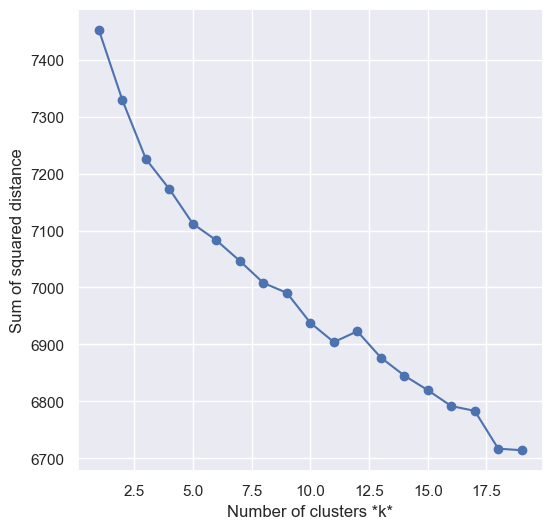

In [15]:
''' Choosing k using elbow method'''
sse = []
list_k = list(range(1, 20))

for k in list_k:
    km = KMeans(
                n_clusters = k, 
                init = "k-means++", 
                n_init = 10, 
                max_iter = 1000, 
                tol = 0.0001, 
                copy_x = False, 
                algorithm = "lloyd"
                )
    km.fit(X = x)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance')

In [ ]:
'''Choosing k using Silhouette analysis'''

from sklearn.metrics import silhouette_samples #,silhouette_score

for i, k in enumerate([2, 3, 4, 5, 6, 7, 8, 9, 10]):
    fig, ax1 = plt.subplots()
    fig.set_size_inches(5, 5)
    
    # Run the Kmeans algorithm
    km = KMeans(
                n_clusters = k, 
                init = "k-means++", 
                n_init = 10, 
                max_iter = 1000, 
                tol = 0.0001, 
                copy_x = True, 
                algorithm = "lloyd"
                )
    labels = km.fit_predict(X = x)
    centroids = km.cluster_centers_

    # Get silhouette samples
    silhouette_vals = silhouette_samples(x, labels)

    # Silhouette plot
    y_ticks = []
    y_lower, y_upper = 0, 0
    for i, cluster in enumerate(np.unique(labels)):
        cluster_silhouette_vals = silhouette_vals[labels == cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        ax1.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
        ax1.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
        y_lower += len(cluster_silhouette_vals)

    # Get the average silhouette score and plot it
    avg_score = np.mean(silhouette_vals)
    ax1.axvline(avg_score, linestyle='--', linewidth=2, color='green')
    ax1.set_yticks([])
    ax1.set_xlim([-0.1, 1])
    ax1.set_xlabel('Silhouette coefficient values')
    ax1.set_ylabel('Cluster labels')
    ax1.set_title('Silhouette plot for the various clusters', y=1.02)


### Clustering

In [22]:
#Initiate KMeans clustering
k = 6
cluster = KMeans(
                n_clusters = k, 
                init = "k-means++", 
                n_init = 10, 
                max_iter = 1000, 
                tol = 0.0001, 
                copy_x = False, 
                algorithm = "lloyd"
                )

In [23]:
#Get cluster assignments
clustering = cluster.fit_predict(X = x)

In [24]:
# making a datframe with the documents and the clusters they belong
cluster_df = pd.DataFrame([complaints.value_lemm_POS.values, clustering]).T
cluster_df.columns = ["text", "Cluster"]

### Visualization of clusters using wordclouds

In [25]:
#Initialize an instance of wordcloud class
wordcloud = WordCloud(
                max_words = 30,
                background_color = "white",
                relative_scaling = 0.65,
                normalize_plurals = False,
                include_numbers = True,
                )

In [ ]:
'''print the thirty most frequent words in each cluster'''
for i in range(k):
    vectorizer = CountVectorizer(max_features=30, stop_words='english', ngram_range=(1,2), binary=True)
    data_cv = vectorizer.fit_transform(cluster_df.text[cluster_df.Cluster ==i].values).toarray()
    words_freq= pd.DataFrame(data_cv, columns=vectorizer.get_feature_names_out())
    words_freq.index= cluster_df.text[cluster_df.Cluster ==i].index
    words_freq = words_freq.transpose()
    word_freq_sum = words_freq.sum(axis=1).sort_values(ascending=False)
    word_freq_sum = word_freq_sum.to_dict()
    wordcloud.generate_from_frequencies(frequencies = word_freq_sum)
    
    plt.figure()
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.gca().set_axis_off()
    #plt.subplots_adjust(top = 0.95, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
    #plt.margins(0,0)
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    max_freq = word_freq_sum[list(word_freq_sum)[0]]
    plt.title(label = "Cluster: " + str(i) + " max_freq: " + str(max_freq), fontdict = None, loc = "center", pad = None)
 
    

## Text Similarity

### Word embeddings

In [55]:
''' this models is a neural network trained to get word similarity based on the probability of word ocurrence
 given a window of 5 words around it, eg.:
 if we feed the next 2 text:
	 i learn better when i study in quiet places
     i understand better when i study in quiet places
the vectors of the words "learn" and "understand" will be closer than others because they are surrounded by the same words (i, better, when, i)
    '''

embeddings = Word2Vec(
					sentences = [clean_text(str(x), tag = True) for x in complaints.loc[:,'value'].values],
					vector_size = 100, 
					sg = 0,
					window = 5, 
					min_count = 25, 
					workers = 10
					)

In [62]:
''' getting vectors and vocab(dict with words and indices)'''
word_vectors = embeddings.wv.vectors
word_vectors_vocab = embeddings.wv.key_to_index # get a dict with words as keys and indices from the word_vectors array as values

(425, 100)


In [93]:
import random
sample = random.sample(word_vectors_vocab.keys(), 1)[0]
print(sample , embeddings.wv.most_similar(sample, topn=5 ))

tired_VERB [('things_NOUN', 0.9940839409828186), ('good_ADJ', 0.993676483631134), ('myself_PRON', 0.9935136437416077), ('dont_NOUN', 0.9931259751319885), ('than_ADP', 0.992881178855896)]


C:\Users\jcgut\AppData\Local\Temp\ipykernel_17248\2833178584.py:2: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sample = random.sample(word_vectors_vocab.keys(), 1)[0]


### Topic extraction with LDA
<details>
    <summary>Click to see more!</summary>
    LDA(Latent Dirichlet Allocation) finds groups of words that appear together more frequently; each of these groups of words is considered a topic. The probability of a topic being present in a document is determined based on the frequency of the words from a certain topic within the document. it works better with long corpus.
</details>


In [193]:
'''Get gensim dictionary, remove stop-words and infrequent words'''

common_dictionary = Dictionary([list(phrases[str(x).split()]) for x in complaints.loc[:,'value_lemm_POS'].values])
common_dictionary.filter_extremes(no_below = 25)
remove_ids = [common_dictionary.token2id[x] for x in stopwords.words('english') if x in common_dictionary.token2id]

common_dictionary.filter_tokens(bad_ids = remove_ids)
common_corpus = [common_dictionary.doc2bow(text) for text in [list(phrases[str(x).split()]) for x in complaints.loc[:,'value_lemm_POS'].values]]

In [194]:
#Train LDA
lda = LdaModel(common_corpus, num_topics = 8)  

In [195]:
''' getting words with higher probability inside each topic'''
for i in range(8):    
    topic = lda.get_topic_terms(topicid=i, topn = 10)
    topic = [common_dictionary[word] for word, prob in topic]
    print(topic)

['sleep', 'libido', 'energy', 'pain', 'improve', 'lack', 'anxiety', 'energy_level', 'fatigue', 'quality']
['energy', 'low', 'weight', 'gain', 'lack', 'focus', 'increase', 'muscle', 'health', 'well']
['energy_level', 'well', 'want', 'healthy', 'get', 'sleep', 'life', 'would_like', 'feel', 'know']
['weight', 'lose_weight', 'age', 'back', 'get', 'body_fat', 'want', 'cholesterol', 'gain', 'low']
['feel', 'physical', 'health', 'mental', 'like', 'well', 'want', 'look', 'performance', 'age']
['hormone', 'energy', 'weight_loss', 'overall_health', 'get', 'improve', 'balance', 'health', 'hormone_balance', 'lose']
['energy', 'need', 'want', 'blood', 'body', 'well', 'feel', 'take', 'work', 'test']
['health', 'increase', 'strength', 'improve', 'muscle', 'body', 'want', 'energy', 'function', 'maintain']


In [222]:
complaints.loc[181,'value']

'i want a customized plan for my health going into the latter part of my life   i currently feel it is to generalized   healthy longevity is my goal '

In [223]:
conv_text = common_dictionary.doc2bow(list(phrases[clean_text(str(complaints.loc[181,'value'])).split()]))
lda[conv_text]

[(0, 0.011368361),
 (1, 0.011370468),
 (2, 0.3806458),
 (3, 0.15304622),
 (4, 0.011392918),
 (5, 0.011376591),
 (6, 0.011380397),
 (7, 0.40941918)]

## How to report results
<details>
<summary>Click to see more!</summary>

- Compare to a majority baseline, other model, simpler model, an estimate ..., and find statistical significance(1 - probability of getting the results due to random chance). 

- make the results visual by line plot, distribution plots(histograms), heat maps, choropleth maps(geopandas), facet grids

</details>

## Ensure Validity
<details>
<summary>Click to see more!</summary>

- Cross-validation: If we’re using a support vector machine, or some other classifier that holds all the data in memory at once, then we use cross-validation. The basic idea here is that we train and test many times, on different parts of the data.

- validation set: This is what we use for a multi-layer perceptron or other neural networks that are trained in increments on small batches of samples. So, an MLP is trained on many small batches; where an SVM is trained on all the data at once, an MLP goes through thousands or even hundreds of thousands of batches. And each training cycle is evaluated against the testing data. This means that the classifier is exposed to the testing data, indirectly, many times throughout the training process.
</details>


## Using pre-trained LLM(large language models) models

### Embeddings(from spacy or openai) to extract information from documents with new or specific information 
<details>
<summary>Click to see more!</summary>
transforming text into embeddings, storing them in a cloud database, and using the database to find information from the document
</details>


In [8]:
# get access to openai API
from dotenv import load_dotenv
import openai

load_dotenv()
openai.api_key = os.getenv('openai_API_key')

In [ ]:
""" to get the number of tokens in a text(in this example all the survey's responses for complaint). 
This is necessary to meet the token's maximum limit of openai's models
"""
import tiktoken

def num_tokens_from_string(string: str, encoding_name: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.encoding_for_model("text-davinci-002")
    num_tokens = len(encoding.encode(string))
    return num_tokens

#responses = complaints.value.values.tolist()
#joined_responses=" ".join(responses)
#joined_responses
num_tokens_from_string(joined_responses, "text-davinci-002")


In [78]:
# Define a function to extract text from a PDF file
def extract_text(pdf_path):  
    import PyPDF2

    with open(pdf_path, 'rb') as pdf_file:
        pdf_reader = PyPDF2.PdfFileReader(pdf_file)
        text = ''
        for page_num in range(pdf_reader.numPages):
            page = pdf_reader.getPage(page_num)
            text += page.extractText()
    return text

In [47]:
# Define a function to create the table for storing document embeddings
def create_embedding_table(db_connection):
    cursor = db_connection.cursor()
    cursor.execute("""
        CREATE TABLE IF NOT EXISTS document_embeddings (
            id serial PRIMARY KEY,
            sent_text text NOT NULL,
            embedding bytea
        )
    """)
    db_connection.commit()
    cursor.close()

In [81]:
def calculate_embedding(text, module='spacy'):
    
    if module=='openai':
        model="text-embedding-ada-002"
        embedding = np.array(openai.Embedding.create(input = [text], model=model)['data'][0]['embedding'])
        from time import sleep
        sleep(20) #this is to comply with the limit of maximun 3 embedding requests per min

    else:
        nlp = spacy.load("en_core_web_sm")
        embedding = nlp(text).vector
    
    return embedding

In [76]:
# Define a function to save document embeddings to a Google Cloud PostgreSQL database
def save_document_embeddings(pdf_path, db_connection):
    
    # extract the text from the PDF
    text = extract_text(pdf_path)

    # To separate the document in sentences with spacy en_core_web_sm and get a list with text and its corresponding vector(from the pre-trained spaCy model)
    text = text.replace("\n", " ").replace("\xa0"," ").replace("\u2022",".") 
    nlp = spacy.load("en_core_web_sm")
    tokens = [[sent.text.strip() , calculate_embedding(sent.text.strip(), module='openai')] for sent in nlp(text).sents]
    
    # Save the document embedding in the database
    cursor = db_connection.cursor()

    for i in range(len(tokens)):
        cursor.execute("INSERT INTO document_embeddings (sent_text, embedding) VALUES (%s, %s)", (tokens[i][0], tokens[i][1].tobytes()))
        db_connection.commit()

    cursor.close()

In [94]:
from scipy.spatial.distance import cosine

# Define a function to calculate the cosine similarity between two vectors
def cosine_similarity(vector1, vector2):
    return 1 - cosine(vector1, vector2)

# Define a function to find the most similar document based on cosine similarity
def find_most_similar_document(question, db_connection):
    cursor = db_connection.cursor()

    # Calculate embeddings for the question and convert to a NumPy array
    question_embedding = calculate_embedding(question, module='openai')

    # Query the database to retrieve all document embeddings
    cursor.execute("SELECT sent_text, embedding FROM document_embeddings")
    rows = cursor.fetchall()

    most_similar_sent_text = None
    highest_similarity = -1  # Initialize with a low value

    for row in rows:
        sent_text, embedding_bytes = row
        # Convert the stored bytes to a NumPy array
        doc_embedding = np.frombuffer(embedding_bytes, dtype=question_embedding.dtype)

        # Calculate cosine similarity between question and document embeddings
        similarity = cosine_similarity(question_embedding, doc_embedding)

        # Update if similarity is higher
        if similarity > highest_similarity:
            highest_similarity = similarity
            most_similar_sent_text = sent_text

    cursor.close()

    return most_similar_sent_text

In [105]:
"""Connect with the postgres g-cloud database and call functions to create a table to store embeddings,
calculate embeddings of the sentences in a document located at pdf_file_path, 
and finally to find the most related part of the document to use as context to answer 
a user's question
"""
import psycopg2
from dotenv import load_dotenv

pdf_file_path = 'C:/Users/jcgut/Downloads/Profile.pdf'

# Specify your PostgreSQL connection parameters
load_dotenv()
db_params = {
    "dbname": os.getenv("dbname"),
    "user": os.getenv("user"),
    "password": os.getenv("password"),
    "host": os.getenv("host"),
    "port": os.getenv("port"),  
            }

# Connect to the PostgreSQL database
connection = psycopg2.connect(**db_params)

# Create the table for storing document embeddings
#create_embedding_table(connection)

# Call the function to calculate and save document embeddings
#save_document_embeddings(pdf_file_path, connection)

# Call the function to retrieve context(most related sentence) fom the database
most_similar = find_most_similar_document("how many years of work experience does she have as AI engineer?", connection)
print(most_similar)
# Close the database connection
connection.close()

Experience Accenture AI Engineer April 2019 - Present  (4 years 7 months)


In [130]:
# to test openai completions
def answer_question(question, document_content):
    response = openai.Completion.create(
        engine="text-davinci-003", #gpt-3.5-turbo-instruct
        prompt=f"Answer the following question: {question}, \n based on the next context: {document_content}",
        max_tokens=50,  # Adjust max tokens as needed
    )
    return response.choices[0].text

In [128]:
# to test openai completions
question = "how much time of work experience does she have as AI engineer?"
context = most_similar
answer = answer_question(question,context)
print(answer)



She has 4 years of work experience as an AI engineer.


In [138]:
# to use API.py to get an anwers based on the embeddings previously stored in the postgres database
import requests

url = 'http://127.0.0.1:5000/get_answer'
question = "what topics does she like to read and write about?"

data = {'question': question}
response = requests.post(url, json=data)
result = response.json()
print(result['answer'].strip())

The person likes to read and write about inspiring AI developments and innovations that could change the way we live.
